In [3]:
##############################
# Goal of this code is to generate paper figures using output from 1.Combine_output.ipynb and 
#   0-4.Calculate_DCIN_coh2.ipynb
#   all data needed for this code is uploaded on Github
# Mu-Ting Chien
# 2024.3.19
#####################################

In [4]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.cm import get_cmap
import cmaps
import sys
sys.path.append('/glade/work/muting/function/')
import KW_diagnostics as KW
import create_my_colormap as mycolor
RWB = mycolor.red_white_blue()

/glade/u/ssg/ch/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
dir_out = '/glade/work/muting/KW/'
CASENAME_LIST2 = list([ 'SST_AQP3_Qobs_27_-4K','SST_AQP3_Qobs_27','SST_AQP3_Qobs_27_4K'])
output_dir_all = dir_out+'output_data/All_3hr_10yr/'
SST_max = np.arange(23,35,4)
figdir = dir_out+'figure/Post_general/paper2/'
os.makedirs(figdir,exist_ok=True) 

# Parameters for coh^2 figure
s2d = 86400
g  = 9.8
re = 6371*1000 #earth radius (m)

# Parameters for KW composite
PI = '\u03C0'
pi = np.pi
bin_simple = np.arange(-pi,pi+1/4*pi,1/4*pi)
bin_simple2 = np.arange(-pi,pi+1/2*pi,1/2*pi)
title = list(['(a) -4K','(b) CTL','(c) +4K'])

In [10]:
#######################################
# Load output from 1. Combine_output.ipynb (all experiments are combined into 1 file)
##########################################
# Load spectrum
data = np.load(output_dir_all+'pr_spectrum_all.npz')
x = data['x']
y = data['y']
raw_sym = data['raw_sym'] #(nx, ny, 3)
r_sym   = data['r_sym']

# Load KW amp, gr, Cp (Cp, zwnum_ave, and freq_ave are calculated from precip lag regression, hovmoller)
data = np.load(output_dir_all+'kw_amplitude_gr_Cp_all.npz')
kw_amp = data['kw_amp']
EAPEGR1 = data['EAPEGR1']
EAPEGR2 = data['EAPEGR2']
EKEGR1 = data['EKEGR1']
EKEGR2 = data['EKEGR2']    
Cp1 = data['Cp1']
Cp2 = data['Cp2']
Cp  = data['Cp']
zwnum_ave = data['zwnum_ave']
freq_ave  = data['freq_ave']
    
# Load kW composite 3D vert struct
data = np.load(output_dir_all+'kw_composite_3D_QTUF_all.npz')
phase = data['phase']
plev_ref = data['plev_ref']
nlev_ref = np.size(plev_ref)
Q_kw  = data['Q_kw']
T_kw  = data['T_kw']
Q1_kw = data['Q1_kw']
Q2_kw = data['Q2_kw']    
T1_kw = data['T1_kw']
T2_kw = data['T2_kw']  
F_kw  = data['F_kw']
U_kw  = data['U_kw']
F1_kw = data['F1_kw']
F2_kw = data['F2_kw']
U1_kw = data['U1_kw']
U2_kw = data['U2_kw'] 
Q_res_kw = Q_kw-Q1_kw-Q2_kw
    
# Load KW composite precip
data = np.load(output_dir_all+'kw_composite_2D_pr_DCIN_SF_all.npz')
pr_kw = data['pr_kw']
    
# Load EOF
data = np.load(output_dir_all+'EOF_all.npz') #,plev_ref=plev_ref, EOFQ1=EOFQ1, EOFQ2=EOFQ2, EOFU1=EOFU1, EOFU2=EOFU2)
EOFQ1 = data['EOFQ1']
EOFQ2 = data['EOFQ2']
EOFU1 = data['EOFU1']
EOFU2 = data['EOFU2']
    
# Load KW composite q
plev_lf_min = np.array([750,750,750])
plev_lf_max2 = np.array([850,850,850]) 
data = np.load(output_dir_all+'kw_composite_3D_q_all.npz')
qv_kw_all = data['qv_kw_all']
#
ilev_lf_min = np.argwhere(plev==plev_lf_min[icase]).squeeze()
ilev_lf_max = np.argwhere(plev==plev_lf_max2[icase]).squeeze() #test
qv_kw_lf = np.mean(qv_kw_all[:,ilev_lf_min:ilev_lf_max+1,:],1)

# Make sure qv_kw and T2_kw has the same vertical dimension
ilevmin_ref = np.argwhere(plev==plev_ref[0]).squeeze()
ilevmax_ref = np.argwhere(plev==plev_ref[-1]).squeeze()
qv_kw_small = qv_kw_all[:,ilevmin_ref:ilevmax_ref+1,:]

ilev_qv_min = np.argwhere(plev_ref==700).squeeze()
qv_kw_LF = np.empty([nphase, np.size(plev_ref), 3])
qv_kw_LF[:, ilev_qv_min:, :] = qv_kw_small[:, ilev_qv_min:, :]
qv_kw_LF[:, :ilev_qv_min, :] = np.nan
    
# Load Coh^2 between PCQ1 and PCQ2
data = np.load(output_dir_all+'coh2_spectrum.npz')
coh_PCQ1_PCQ2 = data['coh_PCQ1_PCQ2']
sin_PCQ1_PCQ2 = data['sin_PCQ1_PCQ2']
cos_PCQ1_PCQ2 = data['cos_PCQ1_PCQ2']
coh_crit = data['coh_crit']
x = data['x']
y = data['y']
freq = data['freq']
zwnum = data['zwnum']

# Load corrcoef between q and precip at each level
data = np.load(output_dir_all+'corrcoef_qv_pr_level.npz')
r = data['r_qv_pr']
plev_r = data['plev']

In [6]:
# loading precip lag regression (used in Fig. 2)
file = output_dir_all+'kw_composite_lag_lon_prano_prkw.nc'
data = Dataset( file, "r", format="NETCDF4")
pr_ano_hovmoller = data.variables['pr_ano_comp'][:]
pr_kw_hovmoller = data.variables['pr_kw_comp'][:]
lon  = data.variables['lon'][:]
tlag = data.variables['tlag'][:]
lont = data.variables['lont'][:]
tlon = data.variables['tlon'][:]

In [15]:
# Load temperature mean state and find melting level
data = np.load(output_dir_all+'Tm_all.npz')
Tm   = data['Tm'] #(plev, icase)
for icase in range(0,3):
    if icase == 0:
        ilev_melt = np.zeros([3]).astype('int')
    dT = Tm[:,icase]-273.15
    ilev_melt[icase] = int(np.argwhere(np.abs(dT)==np.min(np.abs(dT))).squeeze())
print(plev[ilev_melt])

[600 525 450]


In [5]:
print('EAPEGR1:',EAPEGR1)
print('EAPEGR2:',EAPEGR2)
print('EKEGR1:',EKEGR1)
print('EKEGR2:',EKEGR2)

EAPEGR1: [ -4.52107046  -8.31758302 -10.46968778]
EAPEGR2: [3.36178018 2.41463416 2.00412835]
EKEGR1: [0.08518435 0.14760488 0.33506509]
EKEGR2: [ 0.00558808 -0.02365805 -0.04133773]


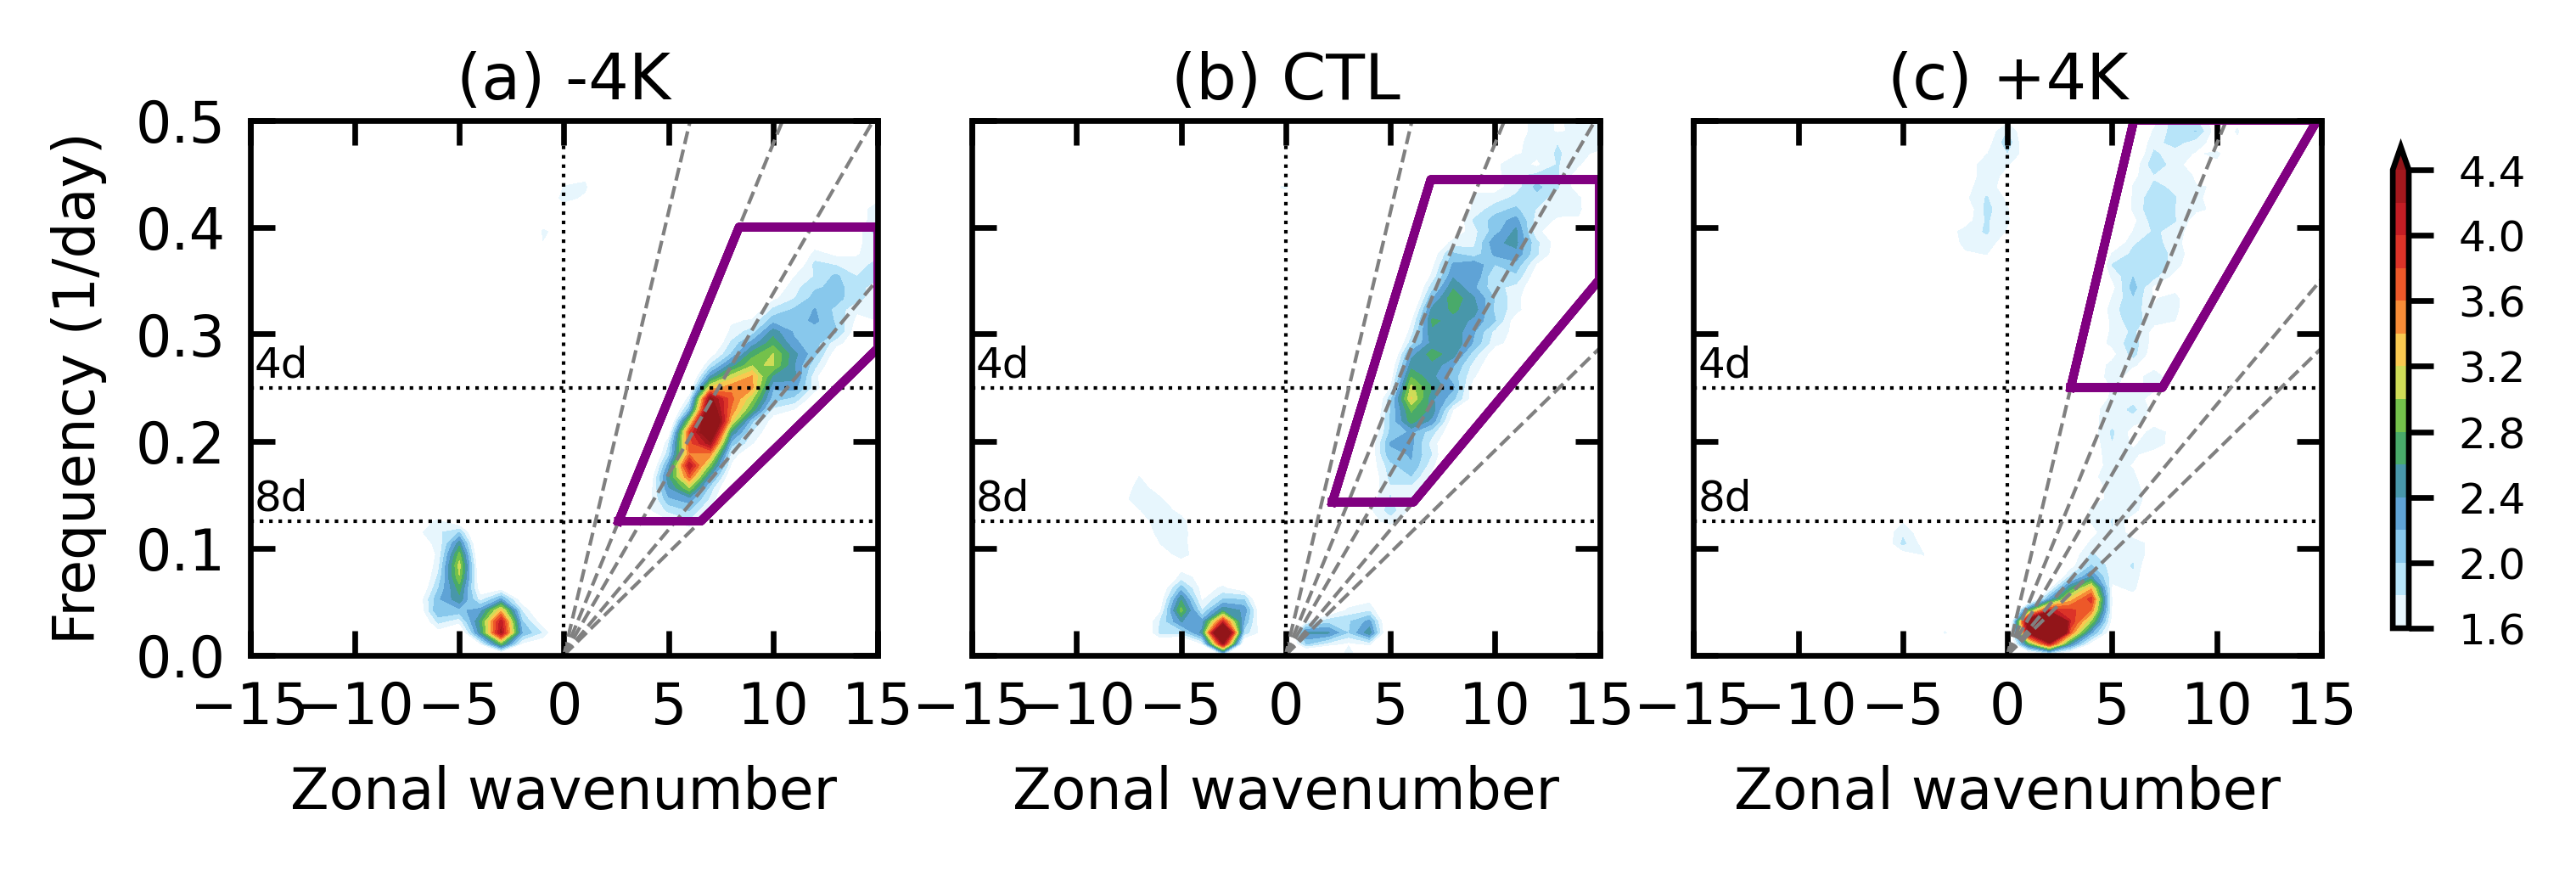

In [13]:
###########################################################
# Fig. 1: Precip signal strength in wavenumber-frequency space
##########################################################

title_diff = list(['(a) 4K/-4K','(b) CTL/-4K','(c) 4K/CTL'])
axid = np.array([0,1,2]).astype('int')
xid = np.array([0,0,0]).astype('int')
yid = np.array([0,1,2]).astype('int')

for iplt in range(0,1):
    if iplt == 0:
        fig_name = 'fig1_rsym_no_centeroid.png' 
        cmap2 = cmaps.WhiteBlueGreenYellowRed
        clevr = np.arange(1.6,4.6,0.2)
        ticks = np.arange(1.6,4.8,0.4)#np.arange(1.2,1.7,0.1)#clevr
    elif iplt == 1:
        fig_name = 'fig1_raw_sym.png' 
        clevr = np.arange(-1,0.5,0.1)
        ticks = np.arange(-1,0.6,0.2)#np.arange(1.2,1.7,0.1)#clevr        
    elif iplt == 2:
        fig_name = 'fig1_diff.png'
        clevr = np.arange(-0.4,0.45,0.05)
        ticks = np.arange(-0.4,0.5,0.1)
    fig,ax = plt.subplots(1,3,figsize=(5.5, 1.5),dpi=600)
    plt.subplots_adjust(left=0.1,right=0.95,top=0.9,bottom=0.2,wspace=0.15)
    plt.rcParams.update({'font.size': 6})
    for v in range(0,3):

        #####################
        # Dispersion curve and CCKW band
        d = np.array([4,8])#([3,6]) # mark 3, 6, 20 day in WK1999
        dname = list(['4d','8d'])#(['3d','6d'])
        if v == 0:
            he = np.array([8,25,50]) 
            hname = list(['8m','25m','50m'])
        elif v==1:
            he = np.array([12,25,90]) # mark equivalent depth for sym spectrum
            hname = list(['12m','25m','90m'])
        elif v == 2:
            he = np.array([25,90,150]) 
            hname = list(['25m','90m','150m'])
        he_all = np.array([8, 12, 25, 50, 150])


        # dispersion curve
        xloc = np.array([12,12,4.9])
        yloc = np.array([0.29,0.47,0.47])
        cp = (g*he_all)**0.5
        zwnum_goal = 0.5/s2d/cp*2*np.pi*re
        # CCKW band
        s_min = (g*he[0])**0.5/(2*np.pi*re)*s2d #slope of he = 8m
        s_max = (g*he[2])**0.5/(2*np.pi*re)*s2d #slope of he = 90m
        kw_tmax_list = np.array([8,7,4])
        kw_tmax = kw_tmax_list[v]
        fmax = np.array([0.4,1/2.25,0.5])
        kw_x = np.array([1/kw_tmax/s_max, 1/kw_tmax/s_min,     15,  15, fmax[v]/s_max, 1/kw_tmax/s_max])
        kw_y = np.array([1/kw_tmax,             1/kw_tmax,  15*s_min, fmax[v],      fmax[v],  1/kw_tmax])


        ax[yid[v]] = plt.subplot(1,3,axid[v]+1)
        if iplt == 0:
            # Plot sym signal strength
            temp = r_sym[:,:,v]
            cf = plt.contourf(x,y,temp,cmap=cmap2,levels = clevr,extend='max') 
        elif iplt == 1:
            temp = np.log10(raw_sym[:,:,v])
            cf = plt.contourf(x,y,temp,cmap='hot_r',levels = clevr,extend='max')         
        elif iplt == 2:
            if v == 0:
                temp = np.log10(raw_sym[:,:,2])-np.log10(raw_sym[:,:,0])
            elif v == 1:
                temp = np.log10(raw_sym[:,:,1])-np.log10(raw_sym[:,:,0])
            elif v == 2:
                temp = np.log10(raw_sym[:,:,2])-np.log10(raw_sym[:,:,1])
            cf = plt.contourf(x,y,temp,cmap='RdBu_r',levels = clevr,extend='both') 
        
        # Mark 3, 6, 20 day period:
        for dd in range(0,np.size(d)):
            plt.plot([-15,15], [1/d[dd],1/d[dd]], 'k',linewidth=0.5, linestyle=':')#'dashed')
            plt.text(-14.8,1/d[dd]+0.01,dname[dd], fontsize=6)
        # Mark CCKW dispersion relationship:
        for hh in range(0,np.size(he_all)):
            plt.plot([0,zwnum_goal[hh]],[0,0.5],'grey',linewidth=0.5,linestyle='dashed')#,linestyle='dashed')#linestyle=':')#linestyle=(0,(5,5)))
            #plt.text(xloc[hh],yloc[hh],hname[hh], fontsize=15)             
        # Mark zwnum == 0:
        plt.plot([0,0],[0,0.5],'k',linewidth=0.5,linestyle=':')#'dashed')
        # Mark CCKW band:
        # y=s*x
        for kk in range(0,np.size(kw_x)):
            plt.plot(kw_x,kw_y,'purple',linewidth=1.2,linestyle='solid')
        
        if iplt == 0 or iplt == 1:
            plt.title(title[v], pad=3, loc='center',fontsize=9)
        else:
            plt.title(title_diff[v], pad=3, loc='center',fontsize=9)
        if v == 0:
            plt.ylabel('Frequency (1/day)')
        plt.xlabel('Zonal wavenumber')
        plt.axis([-15,15,0,0.5])
        plt.xticks([-15,-10,-5,0,5,10,15])
        plt.yticks(np.arange(0,0.6,0.1))
        plt.tick_params(bottom=True,top=True,left=True,right=True)
        if v == 0:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        else:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        plt.tick_params(direction="in")

        # Mark centroid of the data
    cb = fig.colorbar(cf,ax=ax[:],orientation = 'vertical',shrink=.9,\
                    fraction=0.1, aspect=30, pad=0.03)
    cb.ax.tick_params(labelsize=6)
    cb.set_ticks(ticks)  
    plt.savefig(figdir+fig_name,format='png', dpi=600)
    plt.show()
    plt.close()                                

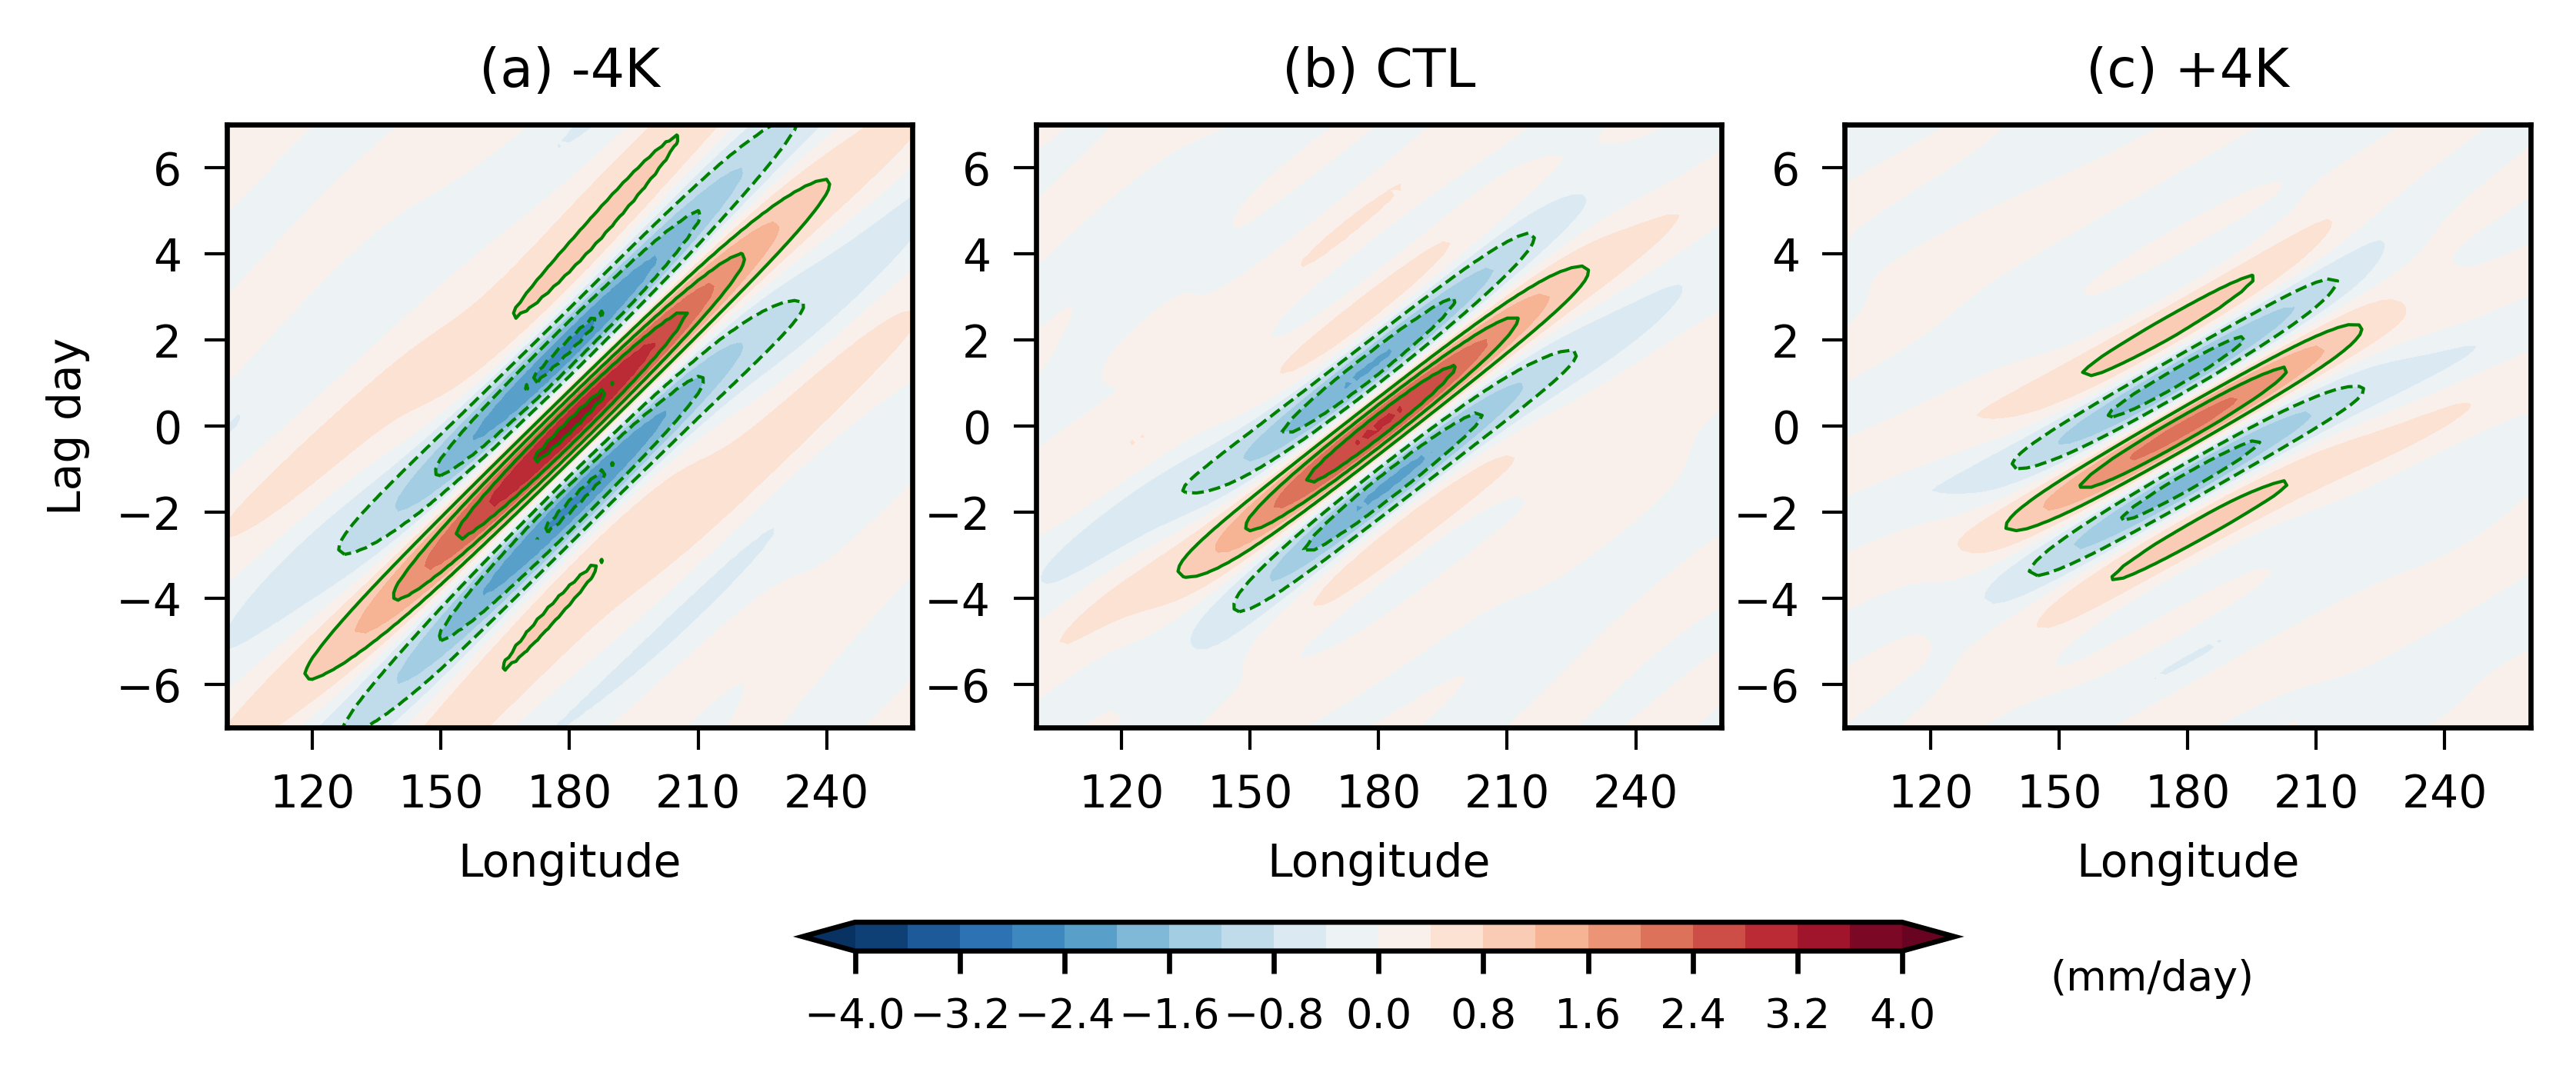

In [8]:
############################################
# Fig. 2: Plot precip hovmoller: kwpr (lag-lon)
##############################################
clev = np.arange(-4,4.4,0.4)
cticks = np.arange(-4,4.8,0.8)
CMAP = 'RdBu_r'
#
clev_pr_kw_p = np.arange(0.8,4.8,0.8)
clev_pr_kw_n = np.arange(-4,0,0.8)

plt_title = list(['(a) -4K','(b) CTL','(c) +4K'])

figname = 'fig2_lon_t_hovmoller_prano_vs_kwpr.png'
fig,axes = plt.subplots(1,3,figsize=(6.4, 2.4),dpi=600)
plt.rcParams.update({'font.size': 7})
for icase in range(0,3):
    ax = plt.subplot(1,3,icase+1)
    plt.subplots_adjust(left=0.15,right=0.93,top=0.9,bottom=0.1,wspace = 0.18)
    cf = plt.contourf(lont, tlon, pr_kw_hovmoller[:,:,icase], levels = clev, cmap=get_cmap(CMAP), zorder=2, alpha=0.99,extend = 'both')
    cn_p = plt.contour(lont, tlon, pr_kw_hovmoller[:,:,icase], levels = clev_pr_kw_p, colors='g', linewidths=0.5)
    cn_n = plt.contour(lont, tlon, pr_kw_hovmoller[:,:,icase], levels = clev_pr_kw_n, linestyles='dashed', colors='g', linewidths=0.5)
    plt.xlabel('Longitude')
    if icase == 0:
        plt.ylabel('Lag day')
    plt.title(plt_title[icase])
    plt.xlim([100,260])
    plt.ylim([-7,7])
    plt.xticks(np.arange(120, 270, step=30))
    plt.yticks(np.arange(-6,8,2))
        
    ax = plt.gca()
    ax.tick_params(width=0.5,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis="both", direction="out")
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    if icase == 2:
        ax.text(0.3, -0.45, '(mm/day)',\
                verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,\
                color='k', fontsize=6.5)
    
cb = fig.colorbar(cf,ax=axes,orientation='horizontal',shrink=.5,fraction=0.1, pad=0.22,aspect=40*1)
cb.ax.tick_params(labelsize=6.5)
cb.set_ticks(cticks)
plt.savefig(figdir+figname,format='png', dpi=600)
plt.show()
plt.close()

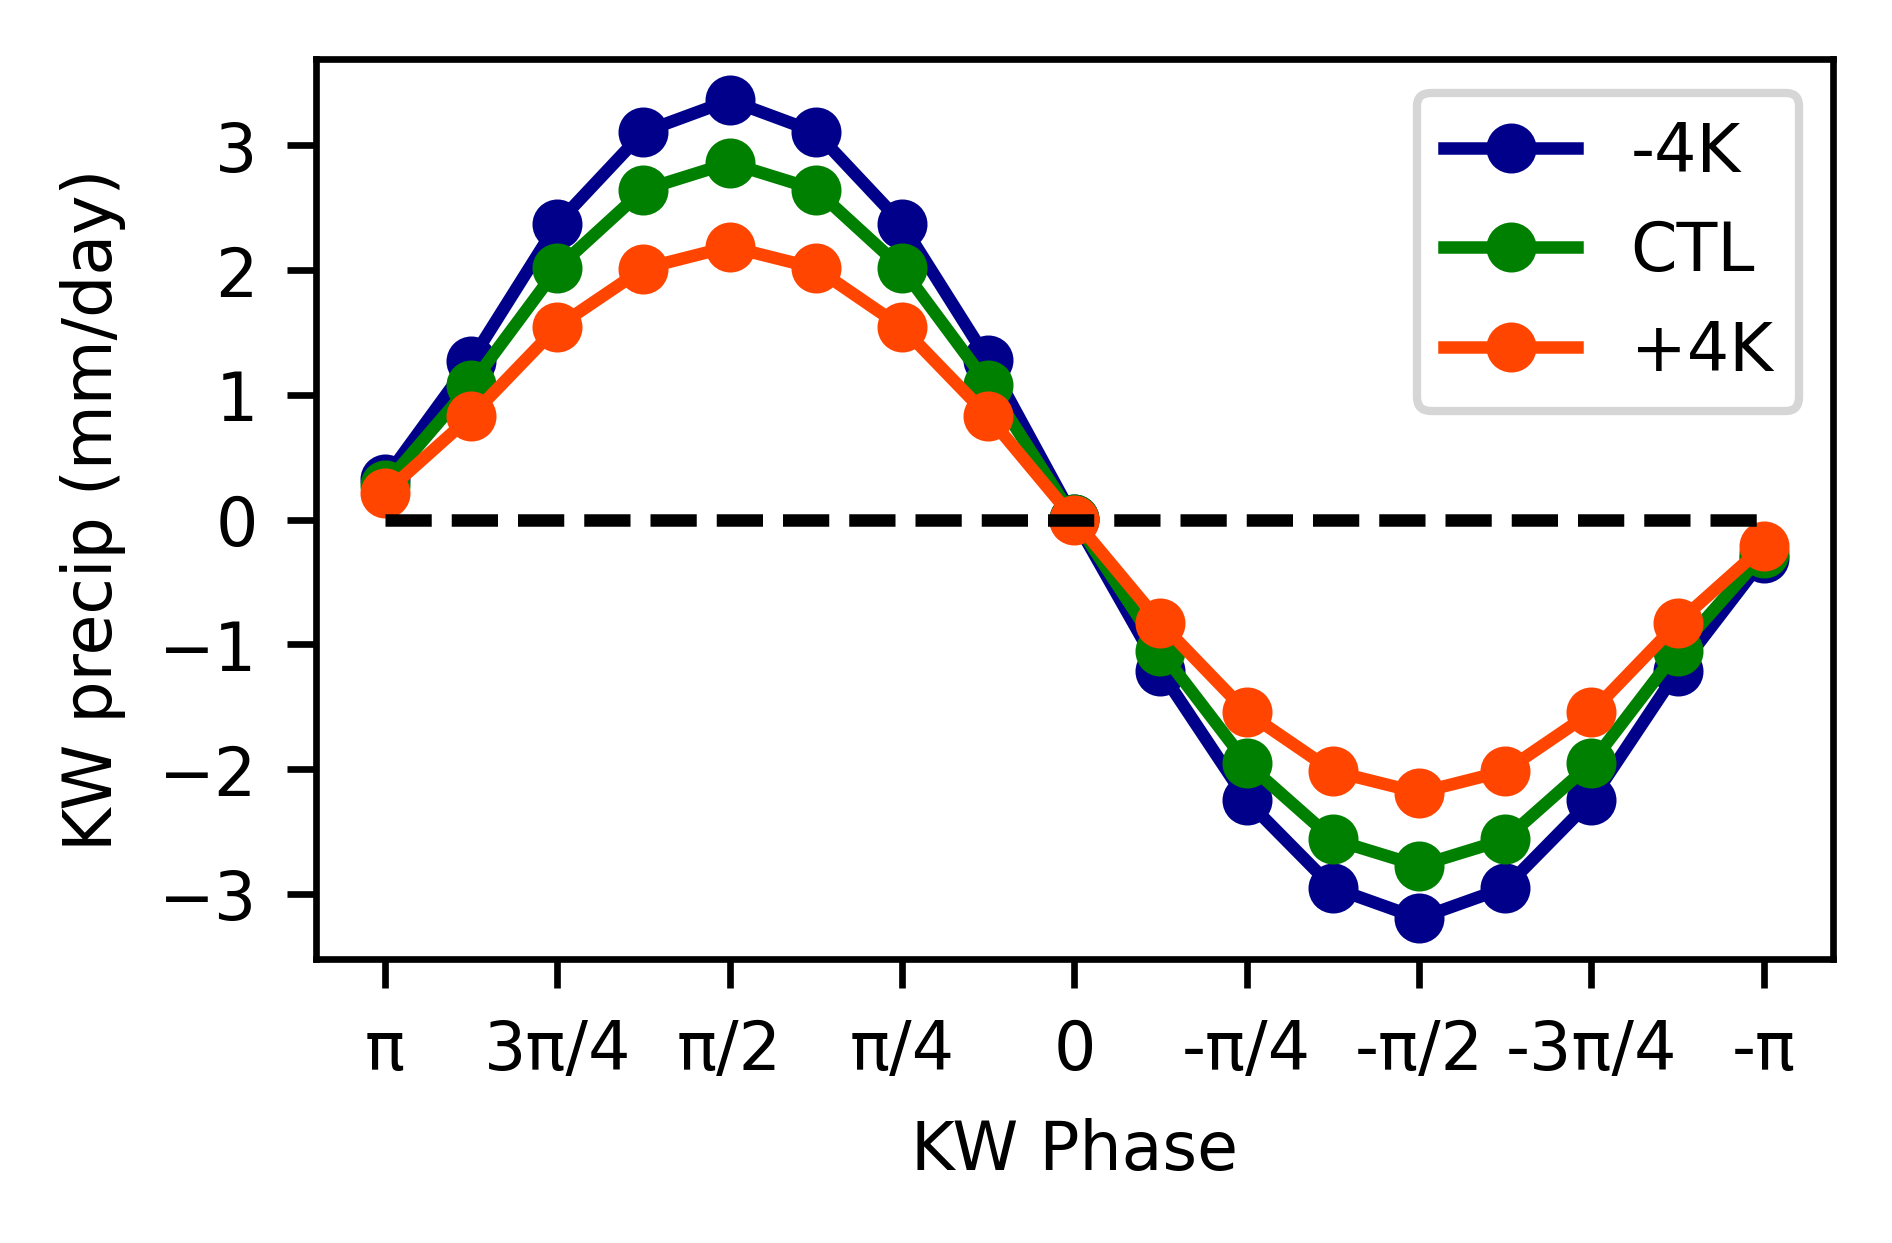

In [7]:
##############################
# Fig. 3: KW composite precip
###############################
plt.rcParams.update({'font.size': 8})
nph = np.size(phase)
zero = np.zeros([nph])
fig_name = 'fig3_KW_pr_1cyc_phase_reversed.png'
fig = plt.subplots(1,1,figsize=(3.2, 2),dpi=600)
plt.subplots_adjust(left=0.2,right=0.99,top=0.95,bottom=0.2)
plt.rcParams.update({'font.size': 8})
plt.plot(phase, pr_kw[:,0],color='darkblue',marker='o',markersize=5)
plt.plot(phase, pr_kw[:,1],color='green',marker='o',markersize=5)
plt.plot(phase, pr_kw[:,2],color='orangered',marker='o',markersize=5)
plt.plot(phase, zero,'k--')
plt.legend(['-4K','CTL','+4K'])
#plt.xticks(bin_simple,('-'+PI,'-3'+PI+'/4','-'+PI+'/2','-'+PI+'/4','0',PI+'/4',PI+'/2','3'+PI+'/4',PI))
plt.xticks(bin_simple,(PI,'3'+PI+'/4',PI+'/2',PI+'/4','0','-'+PI+'/4','-'+PI+'/2','-3'+PI+'/4','-'+PI))
plt.xlabel('KW Phase')
plt.yticks(np.arange(-3,4,1))
plt.ylabel('KW precip (mm/day)')
plt.savefig(figdir+fig_name,format='png', dpi=600)
plt.show()
plt.close()

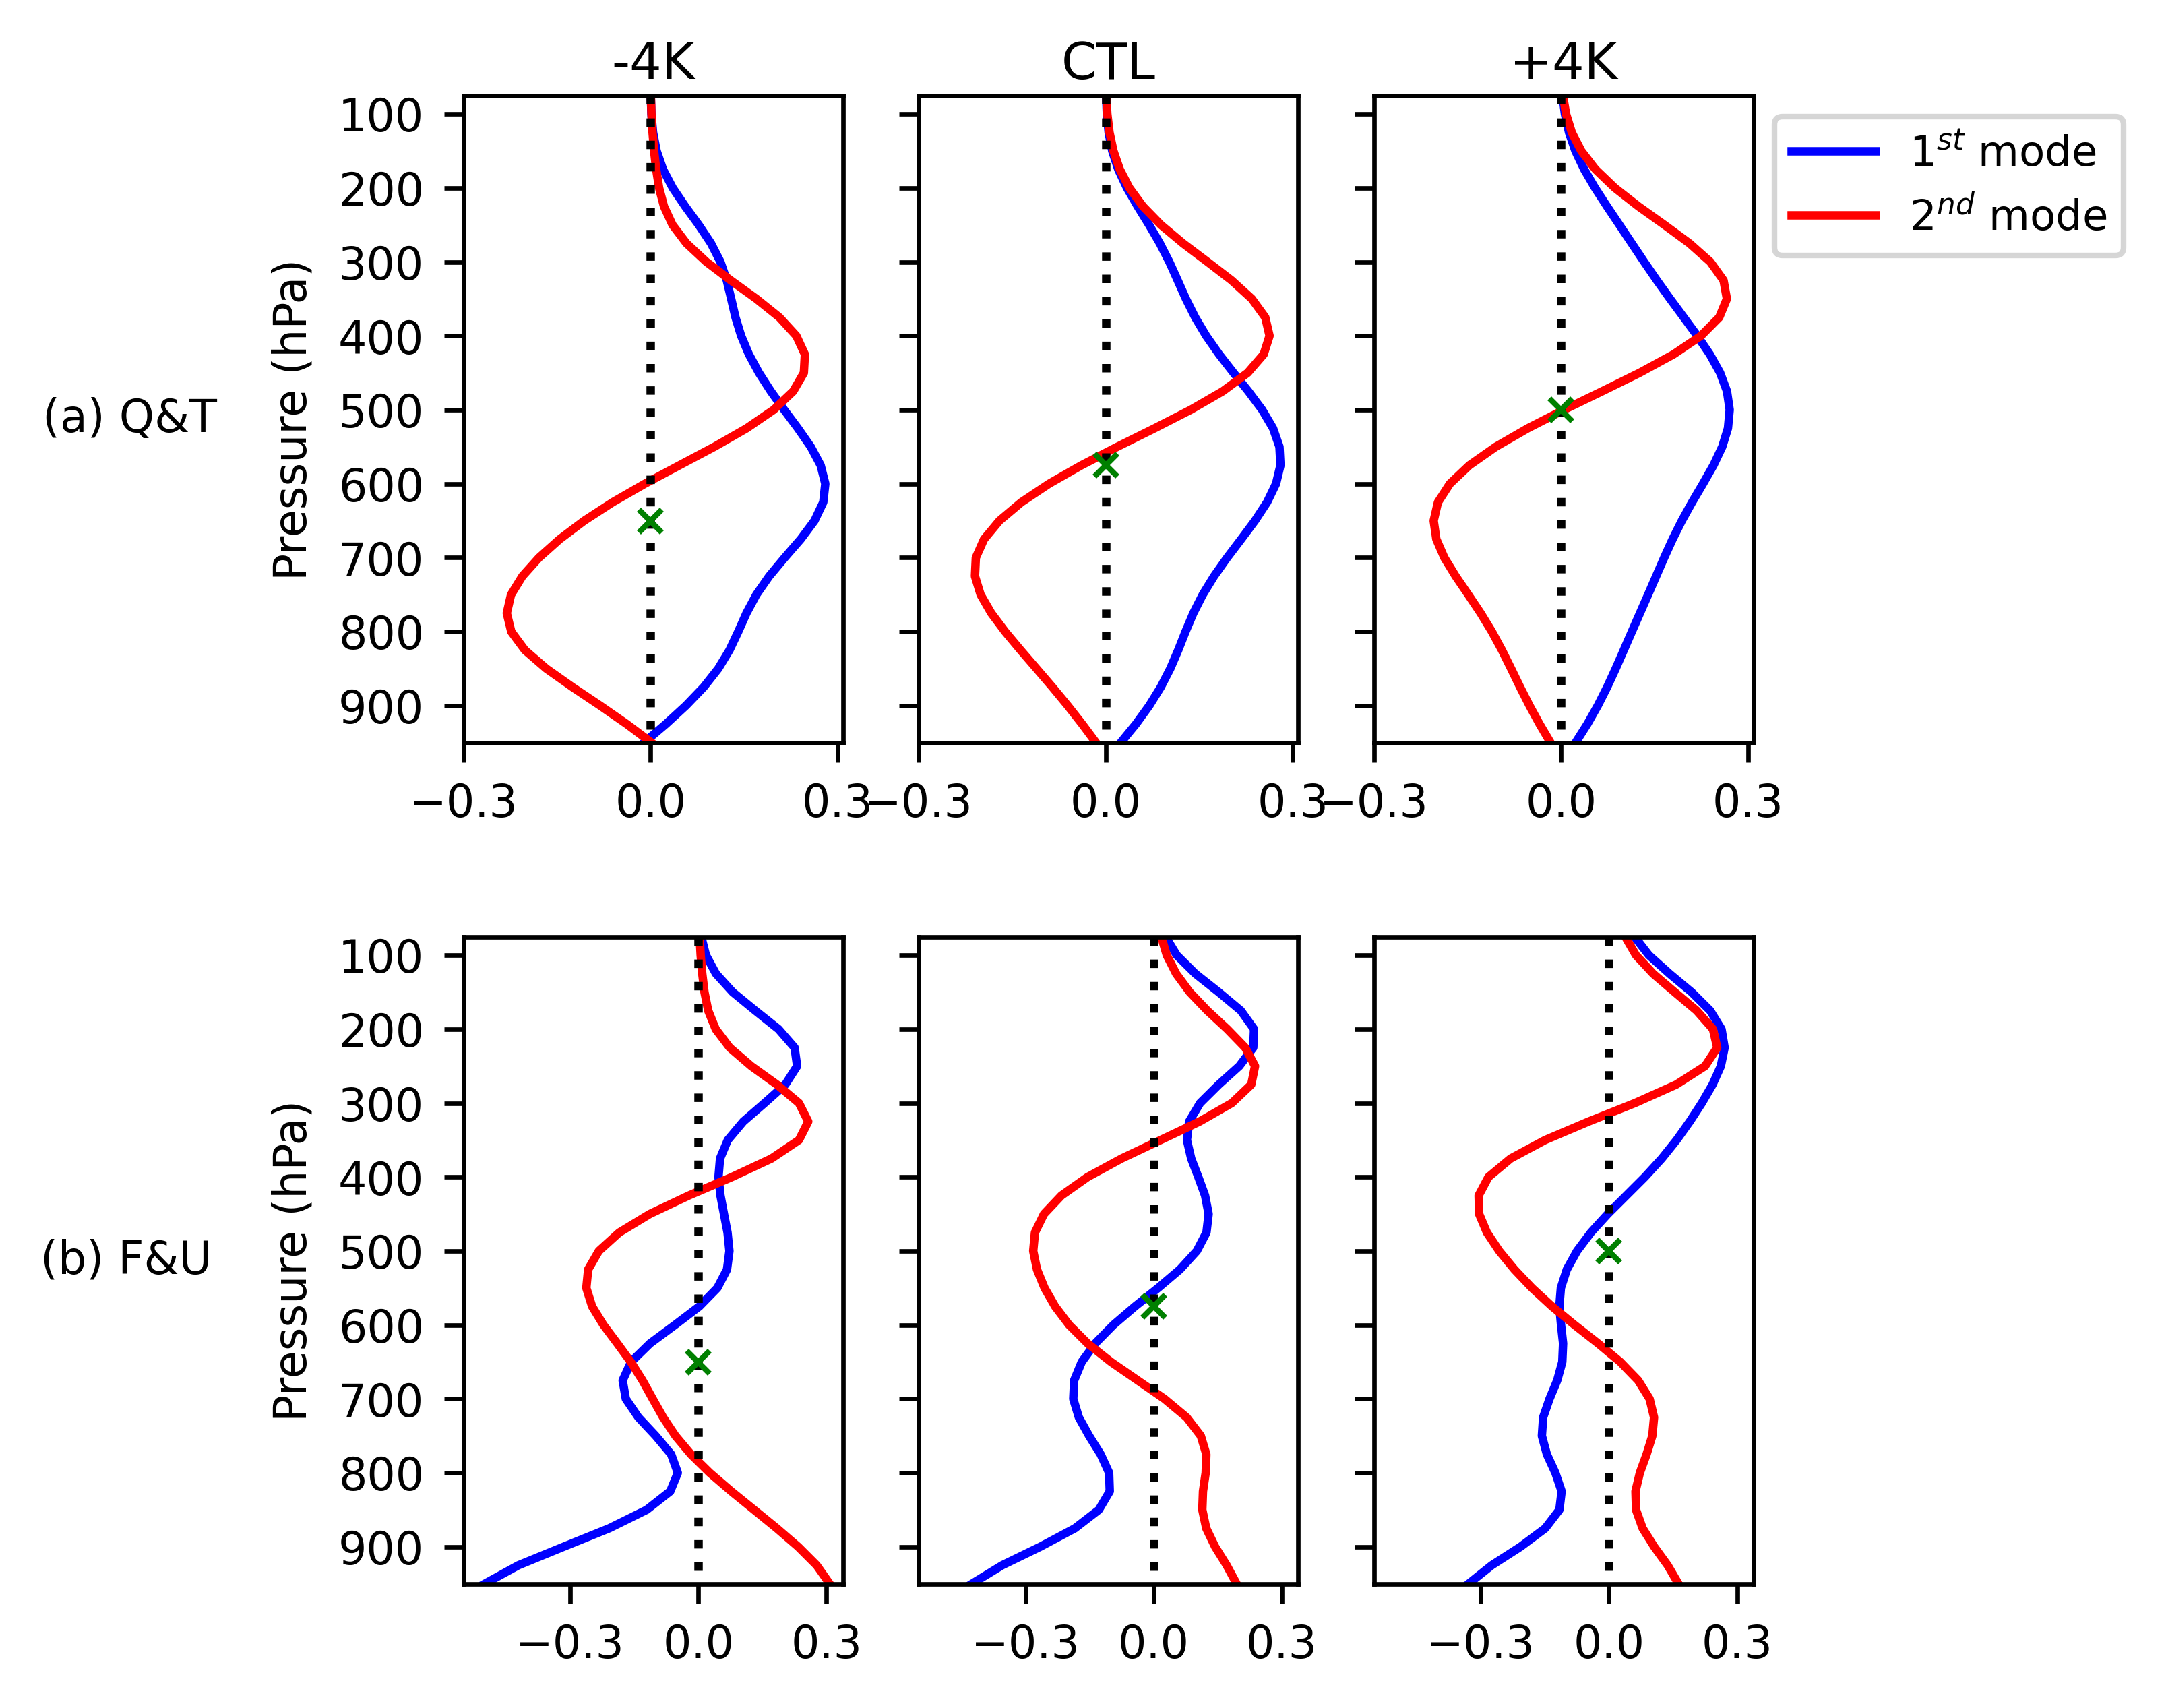

In [49]:
###################################################
# Fig. 4: Plot EOF vertical profile: EOF1, EOFU
###################################################
mark_melting_level = 1

title = list(['(a) -4K','(b) CTL','(c) +4K'])
title_noabc = list(['-4K','CTL','+4K'])
    
# Plot 2 figures together
font = 8
fig,axes = plt.subplots(2,3,figsize=(5.5, 4.6),dpi=600)
plt.subplots_adjust(left=0.22,right=0.8,top=0.9,bottom=0.1,wspace=0.2,hspace=0.3)
plt.rcParams.update({'font.size': font})
zero = np.zeros([nlev_ref])
plev_mid = (np.max(plev_ref)+np.min(plev_ref))/2
for icase in range(0,3):
    #
    # Plot Q and T
    plt.subplot(2,3,icase+1)
    ax = plt.gca()
    plt.plot(EOFQ1[:,icase], plev_ref, 'b')
    plt.plot(EOFQ2[:,icase], plev_ref, 'r')
    plt.xlim([np.min(EOFQ2)*1.1, np.max(EOFQ1)*1.1])
    plt.xticks(np.arange(-0.3,0.6,0.3))
    plt.plot(zero, plev_ref,'k:')
    plt.tick_params(bottom=True,top=False,left=True,right=False)
    plt.ylim([np.min(plev_ref), np.max(plev_ref)]) 
    plt.yticks(np.arange(100,1000,100))
    if icase == 2:
        ax.legend(['1$^{st}$ mode','2$^{nd}$ mode'],bbox_to_anchor=(1, 1), loc='upper left',fontsize=7.5)
    plt.gca().invert_yaxis()
    plt.title(title_noabc[icase], pad=3, loc='center',fontsize=9)
    if icase == 0:
        plt.text(-0.3*3.25,plev_mid,'(a) Q&T',fontsize=8,horizontalalignment='left',verticalalignment='center') 
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        plt.ylabel('Pressure (hPa)')
    else:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
    
    # Mark melting level:
    if mark_melting_level == 1:
        plt.plot( 0, plev_ref[ilev_melt[icase]], 'gx',markersize=4)
    #
    # Plot U and F
    plt.subplot(2,3,icase+4)
    plt.plot(EOFU1[:,icase], plev_ref, 'b')
    plt.plot(EOFU2[:,icase], plev_ref, 'r')  
    plt.xlim([np.min(EOFU1)*1.1, np.max(EOFU2)*1.1])
    plt.xticks(np.arange(-0.3,0.6,0.3))
    plt.plot(zero, plev_ref,'k:')
    plt.tick_params(bottom=True,top=False,left=True,right=False)
    plt.ylim([np.min(plev_ref), np.max(plev_ref)]) 
    plt.yticks(np.arange(100,1000,100))
    plt.gca().invert_yaxis()
    if icase == 0:
        plt.text(np.min(EOFU1)*1.1*2.8,plev_mid,'(b) F&U',fontsize=8,horizontalalignment='left',verticalalignment='center') 
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        plt.ylabel('Pressure (hPa)')
    else:
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
    # Mark melting level:
    if mark_melting_level == 1:
        plt.plot( 0, plev_ref[ilev_melt[icase]], 'gx',markersize=4)

plt.savefig(figdir+'fig4_EOF_QU.png',dpi=600)
plt.show()

In [14]:
print('Melting level:', plev_ref[ilev_melt])

Melting level: [650 575 500]


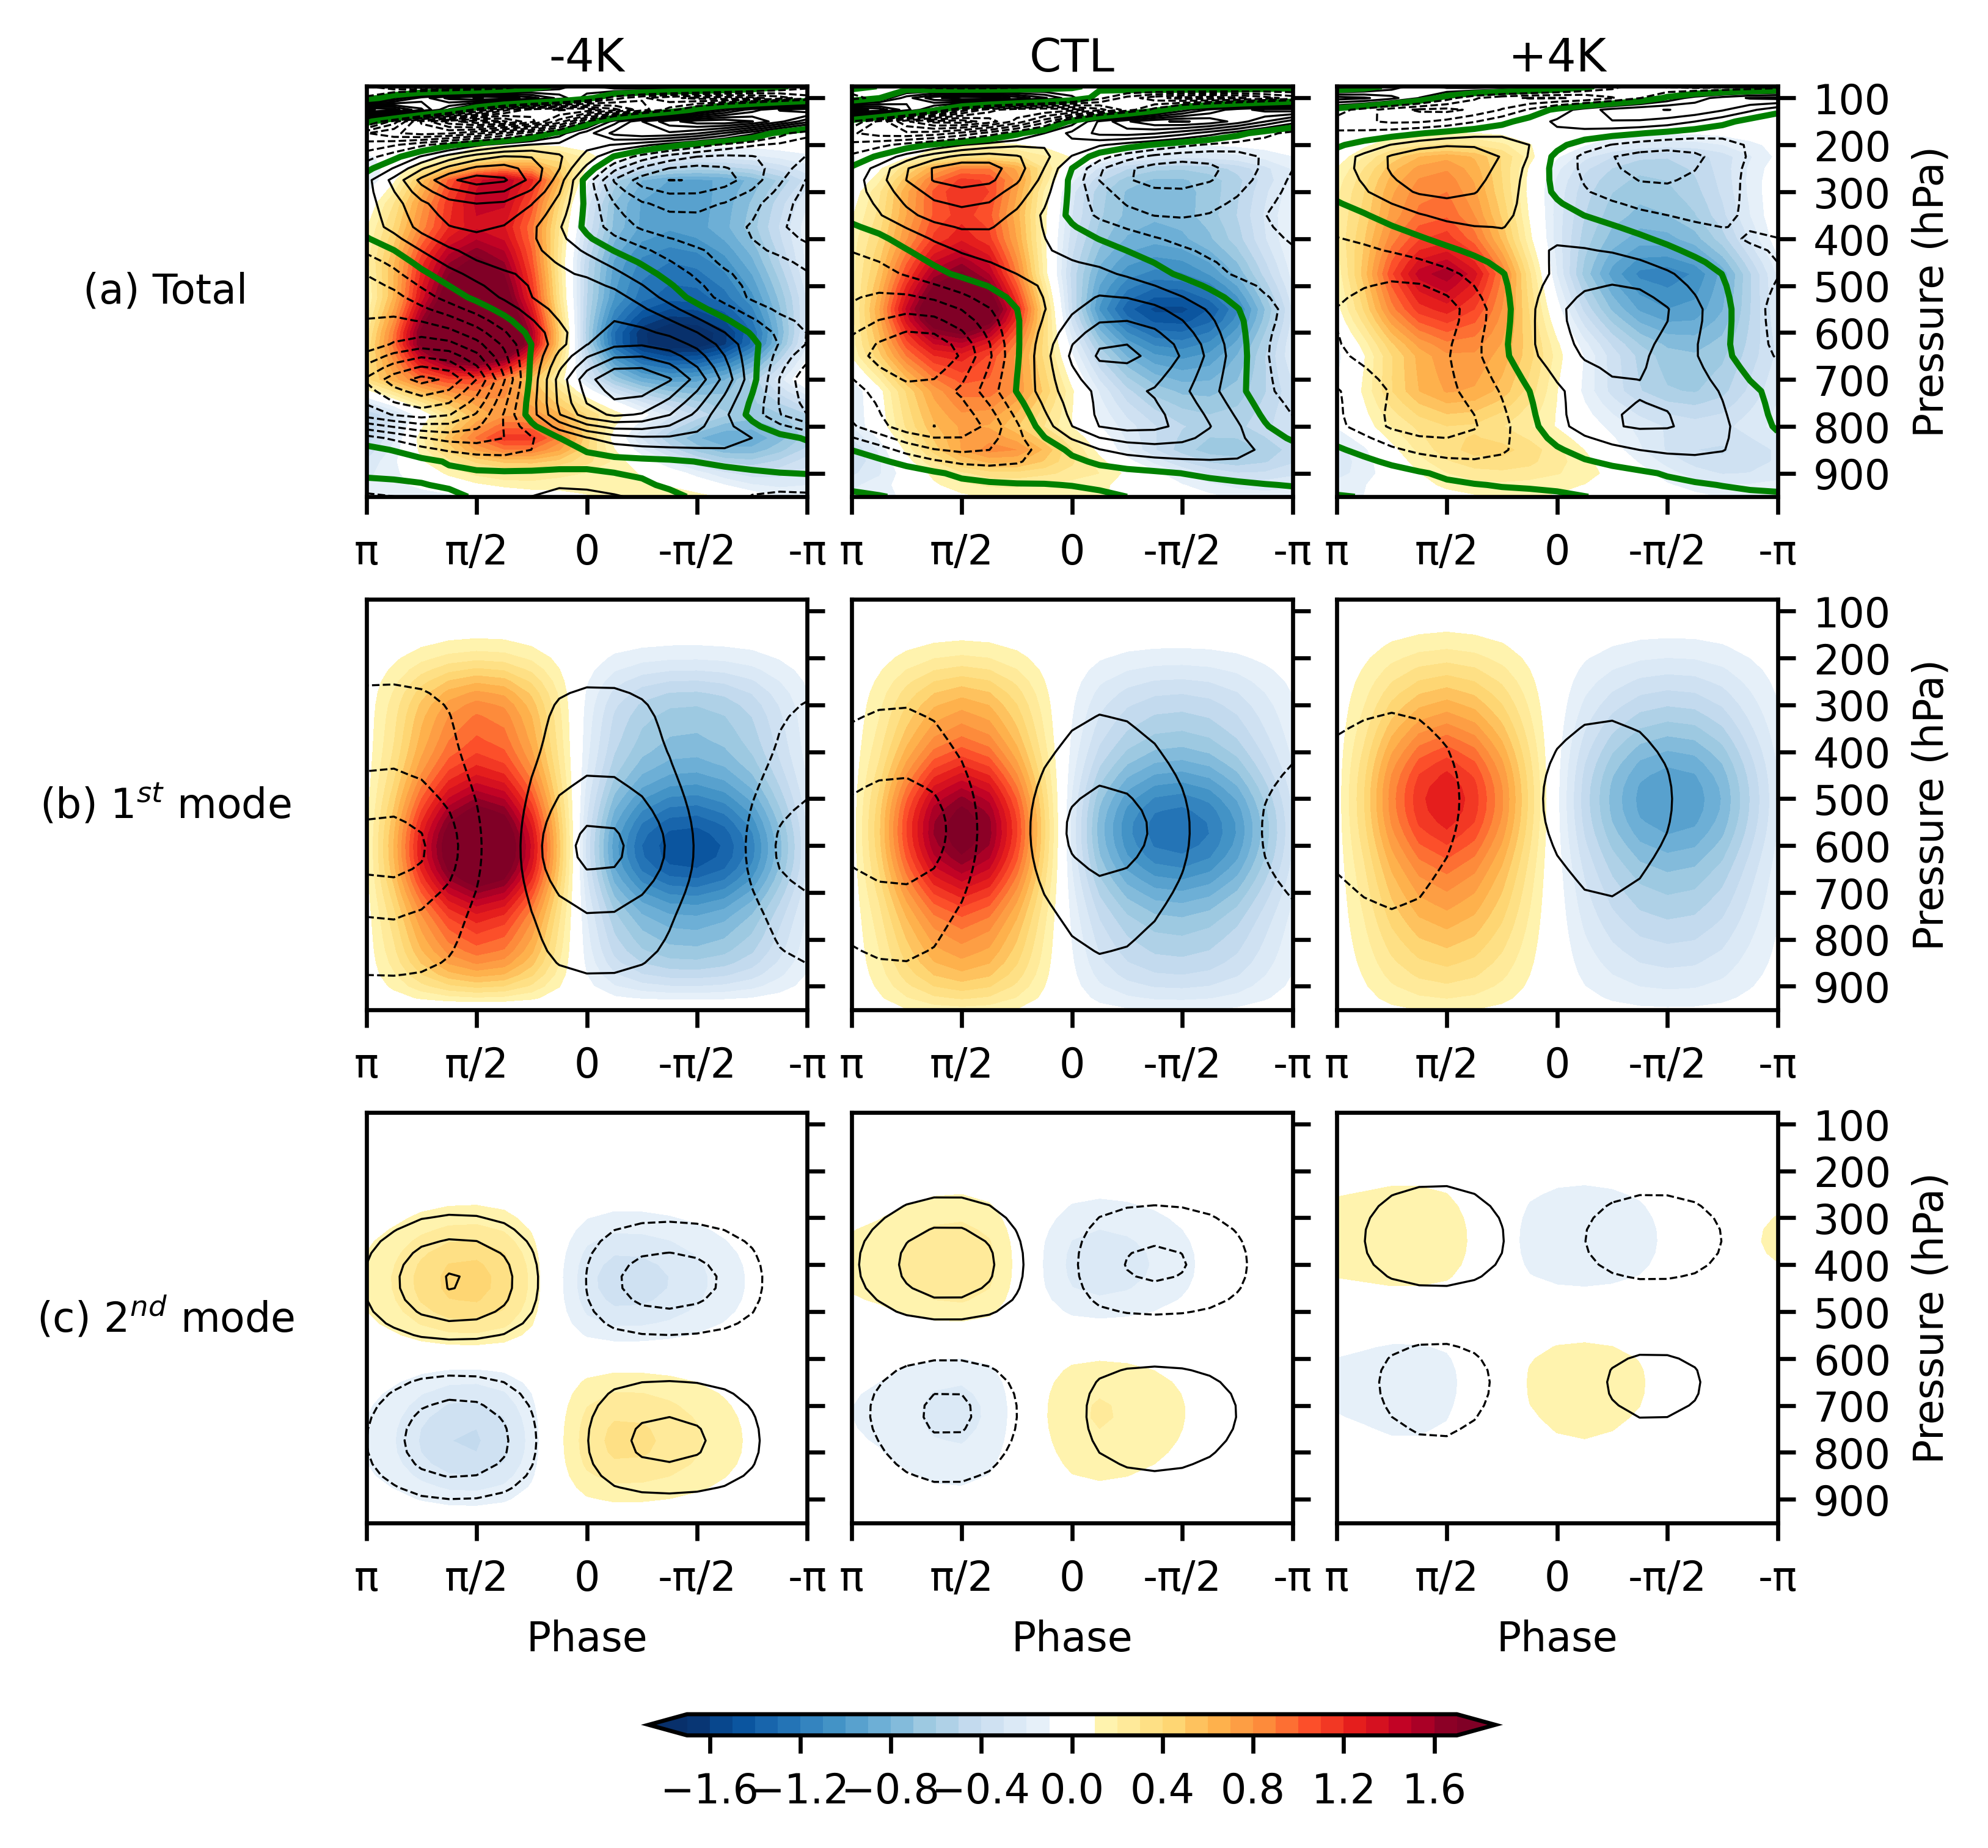

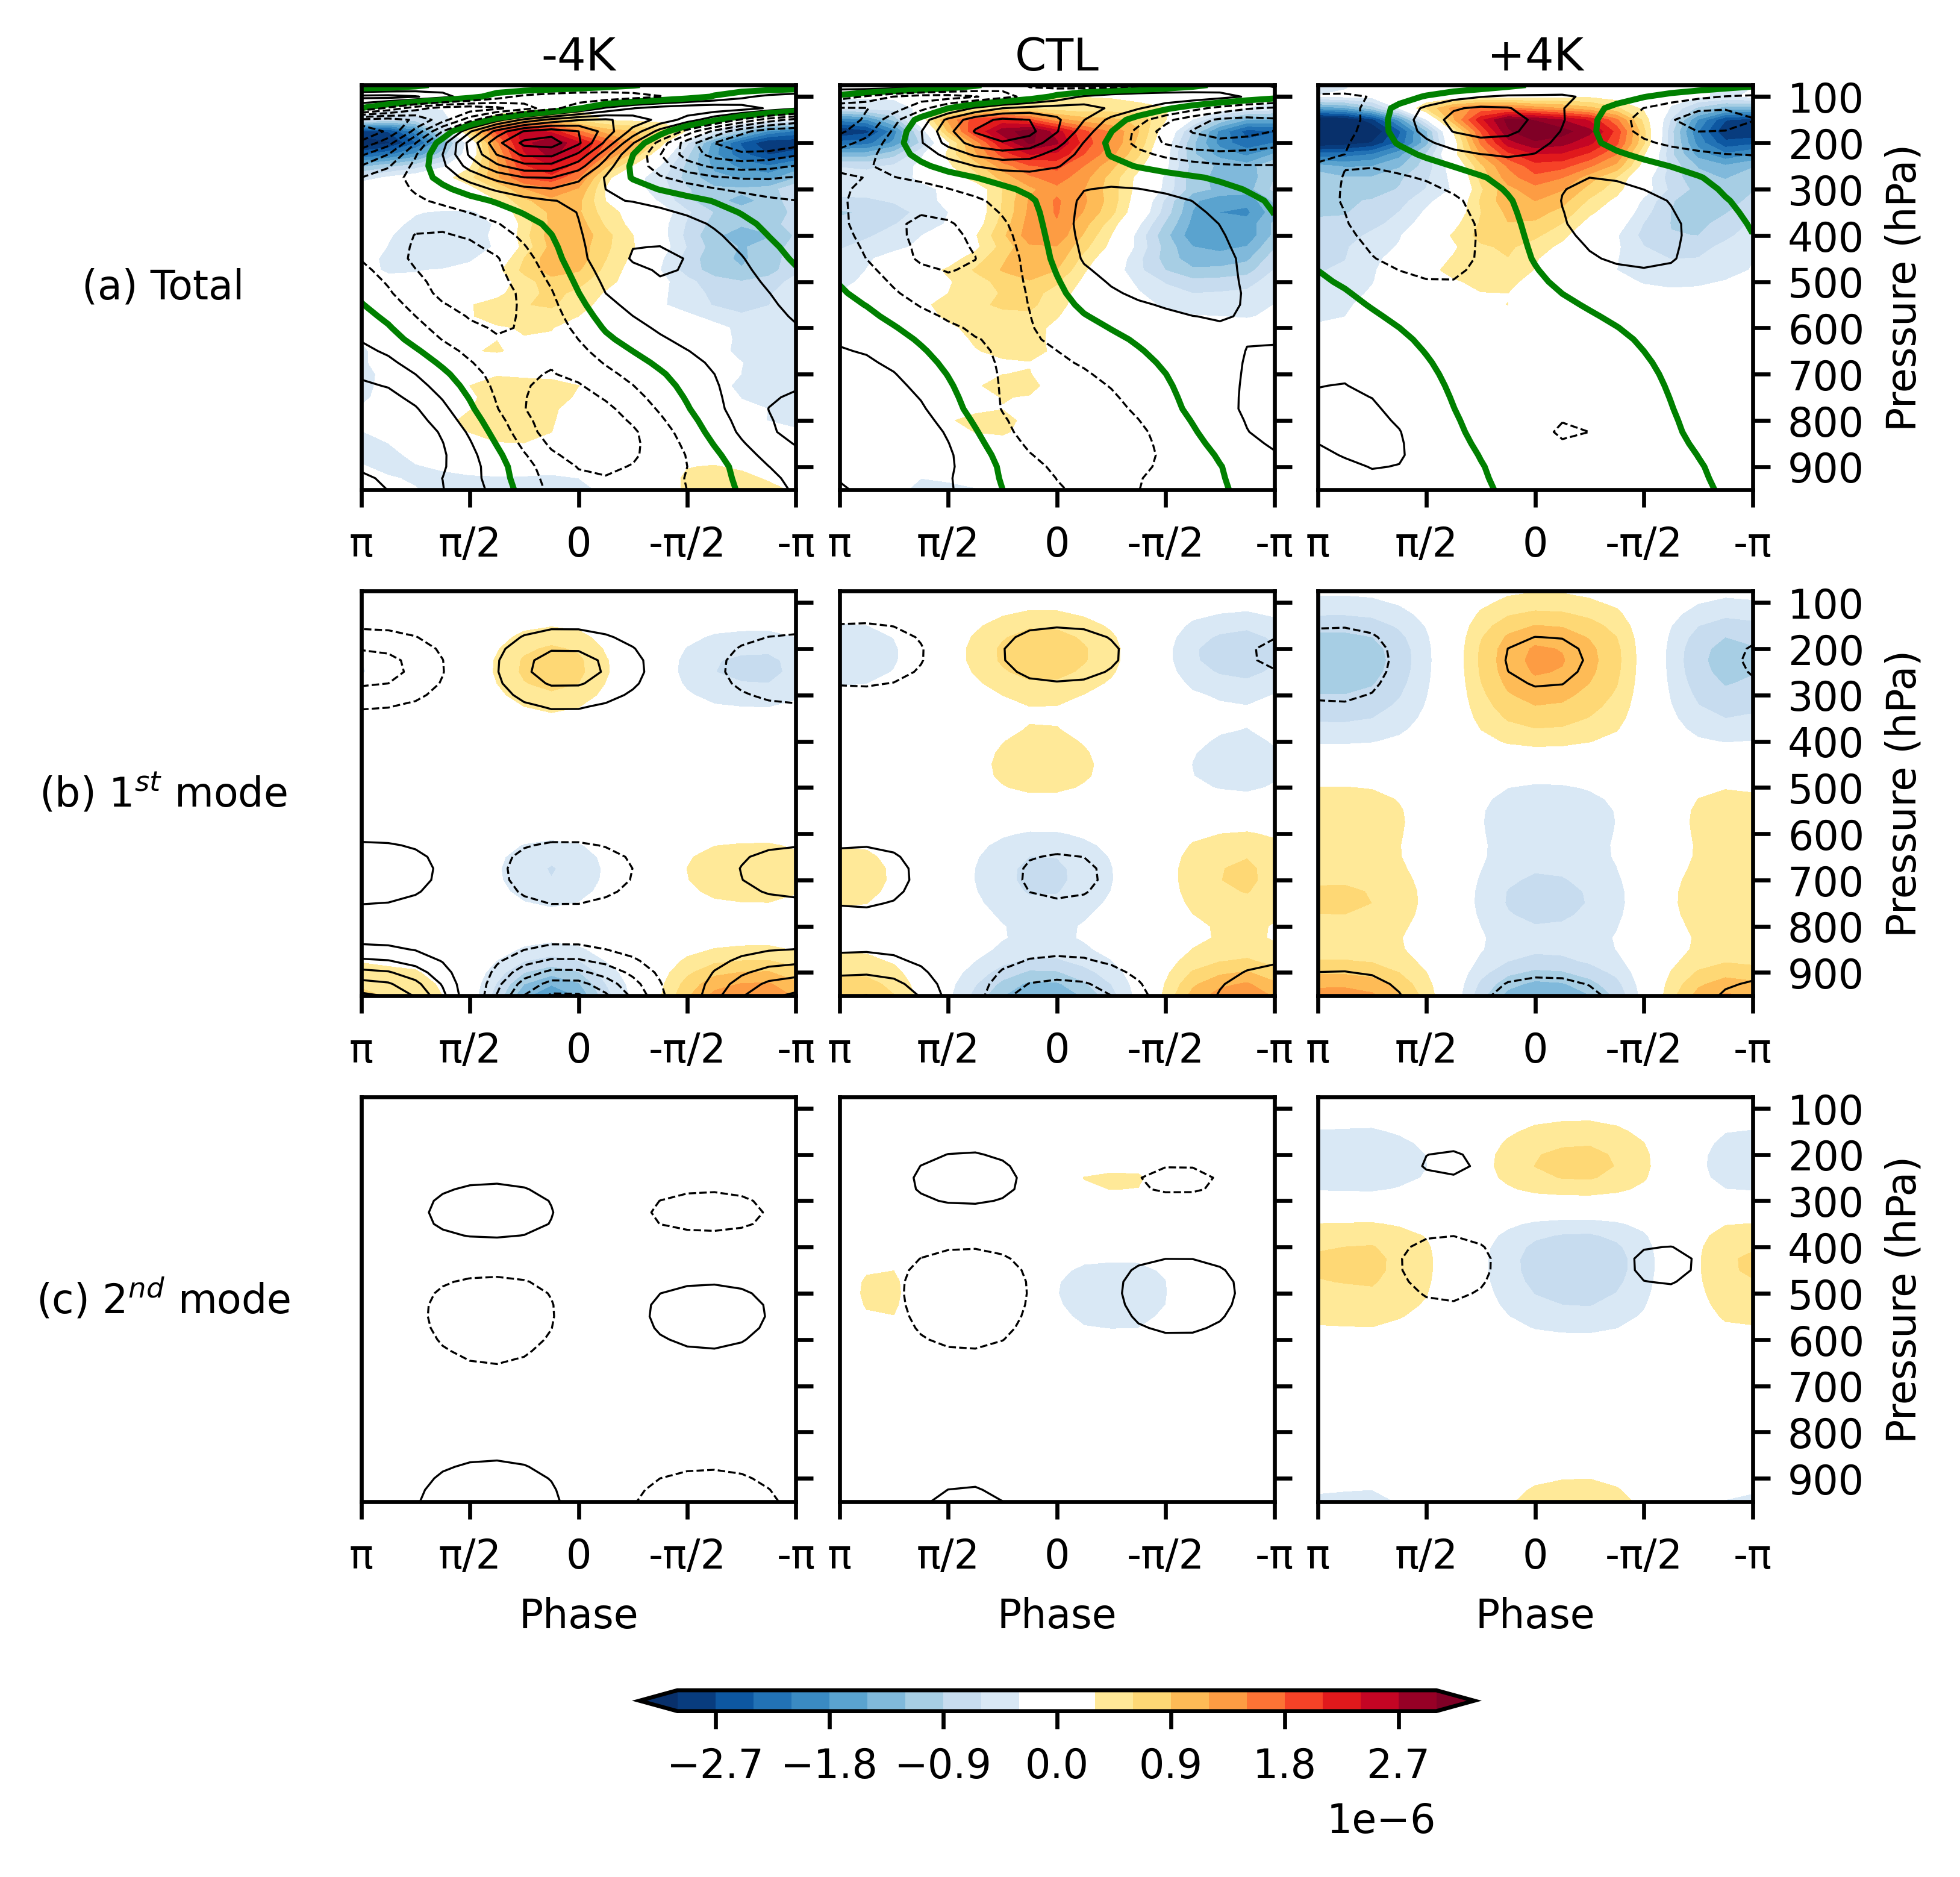

In [8]:
############################
# Fig. 5-6: KW composite vertical structure of Q and T
##############################
plev = plev_ref

plot_fignum = 3 # or 5, if plot_fignum=5, plot extra panels for 1st+2nd modes and residual
txt_xloc = -6
txt_yloc = (np.min(plev)+np.max(plev))/2
row_name = list(['(a) Total','(b) 1$^{st}$ mode','(c) 2$^{nd}$ mode'])
title_noabc = list(['-4K','CTL','+4K'])
clev_0 = 0
font = 8

normalize_by_kwpr = 0 # I think we do not need to normalize by kw precip

for iplt in range(0,2): #(iplt=0, QT, iplt=1, FU)
    
    fig,axes = plt.subplots(3,3,figsize=(5.5, 5.5),dpi=600)
    plt.subplots_adjust(left=0.2,right=0.9,top=0.95,bottom=0,hspace=0.25,wspace=0.1)
    plt.rcParams.update({'font.size': font})
    
    if iplt == 0:
        clev = np.arange(-1.7,1.8,0.1)
        clev_n = np.arange(-0.96,0,0.08)
        clev_p = np.arange(0.08,1.04,0.08)
        var_cf  = globals()['Q_kw']
        var_cn  = globals()['T_kw']
        var1_cf = globals()['Q1_kw']
        var2_cf = globals()['Q2_kw']
        var1_cn = globals()['T1_kw']
        var2_cn = globals()['T2_kw']
    elif iplt == 1:
        clev = np.arange(-3,3.3,0.3)*10**(-6)
        clev_n = np.arange(-4.5,0,0.5)
        clev_p = np.arange(0.5,5,0.5)      
        var_cf = globals()['F_kw']
        var_cn = globals()['U_kw']
        var1_cf = globals()['F1_kw']
        var2_cf = globals()['F2_kw']
        var1_cn = globals()['U1_kw']
        var2_cn = globals()['U2_kw']
        
    for i in range(0,3): #icase
        
        if normalize_by_kwpr == 1:
            var_cf[:,:,i] = var_cf[:,:,i]/kw_amp
            var_cn[:,:,i] = var_cn[:,:,i]/kw_amp
        
        plt.subplot(plot_fignum,3,i+1)
        ax = plt.gca()
        plt.title(title_noabc[i], pad=3, loc='center',fontsize=9)
        xx, yy = np.meshgrid(phase, plev)
        cf  = plt.contourf(xx, yy, var_cf[:,:,i].T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, var_cn[:,:,i].T, levels=clev_p, colors='k', linewidths=0.4)
        cn_0 = plt.contour(xx, yy, var_cn[:,:,i].T, levels=clev_0, colors='g', linewidths=1.2)
        cn_n = plt.contour(xx, yy, var_cn[:,:,i].T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
        plt.ylim([np.min(plev),np.max(plev)])
        plt.yticks(np.arange(100,1000,100))
        plt.gca().invert_yaxis()
        #plt.xticks(bin_simple2,('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        plt.xticks(bin_simple2,(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=False,right=True)
        if i == 0:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
            plt.text(txt_xloc,txt_yloc,row_name[0],fontsize=8,horizontalalignment='center',verticalalignment='center') 
        elif i == 1:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        elif i == 2:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
            ax.yaxis.set_label_position("right")
            ax.set_ylabel('Pressure (hPa)',fontsize=font)

        plt.subplot(plot_fignum,3,i+1+3)
        ax = plt.gca()
        cf  = plt.contourf(xx, yy, var1_cf[:,:,i].T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, var1_cn[:,:,i].T, levels=clev_p, colors='k', linewidths=0.4)
        cn_n = plt.contour(xx, yy, var1_cn[:,:,i].T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
        plt.ylim([np.min(plev),np.max(plev)])
        plt.yticks(np.arange(100,1000,100))
        plt.gca().invert_yaxis()
        #plt.xticks(bin_simple2,('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        plt.xticks(bin_simple2,(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=False,right=True)
        if i == 0:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
            plt.text(txt_xloc,txt_yloc,row_name[1],fontsize=8,horizontalalignment='center',verticalalignment='center') 
        elif i == 1:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        elif i == 2:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
            ax.yaxis.set_label_position("right")
            ax.set_ylabel('Pressure (hPa)',fontsize=font)

        plt.subplot(plot_fignum,3,i+1+6)
        ax = plt.gca()
        cf  = plt.contourf(xx, yy, var2_cf[:,:,i].T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, var2_cn[:,:,i].T, levels=clev_p, colors='k', linewidths=0.4)
        cn_n = plt.contour(xx, yy, var2_cn[:,:,i].T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4) 
        plt.ylim([np.min(plev),np.max(plev)])
        plt.yticks(np.arange(100,1000,100))
        plt.gca().invert_yaxis()
        #plt.xticks(bin_simple2,('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        plt.xticks(bin_simple2,(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=False,right=True)
        if i == 0:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
            plt.text(txt_xloc,txt_yloc,row_name[2],fontsize=8,horizontalalignment='center',verticalalignment='center') 
        elif i == 1:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        elif i == 2:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
            ax.yaxis.set_label_position("right")
            ax.set_ylabel('Pressure (hPa)',fontsize=font)

        plt.xlabel('Phase',fontsize=font)
    cb = plt.colorbar(cf,ax=axes[:,:],orientation = 'horizontal', shrink=.6, aspect=40,pad=0.1) 
    if iplt == 0:
        plt.savefig(figdir+'fig5_Q_T_KW_1st_2nd_phase_reversed.png',dpi=600)
    else:
        plt.savefig(figdir+'fig6_F_U_KW_1st_2nd_phase_reversed.png',dpi=600)
    plt.show()


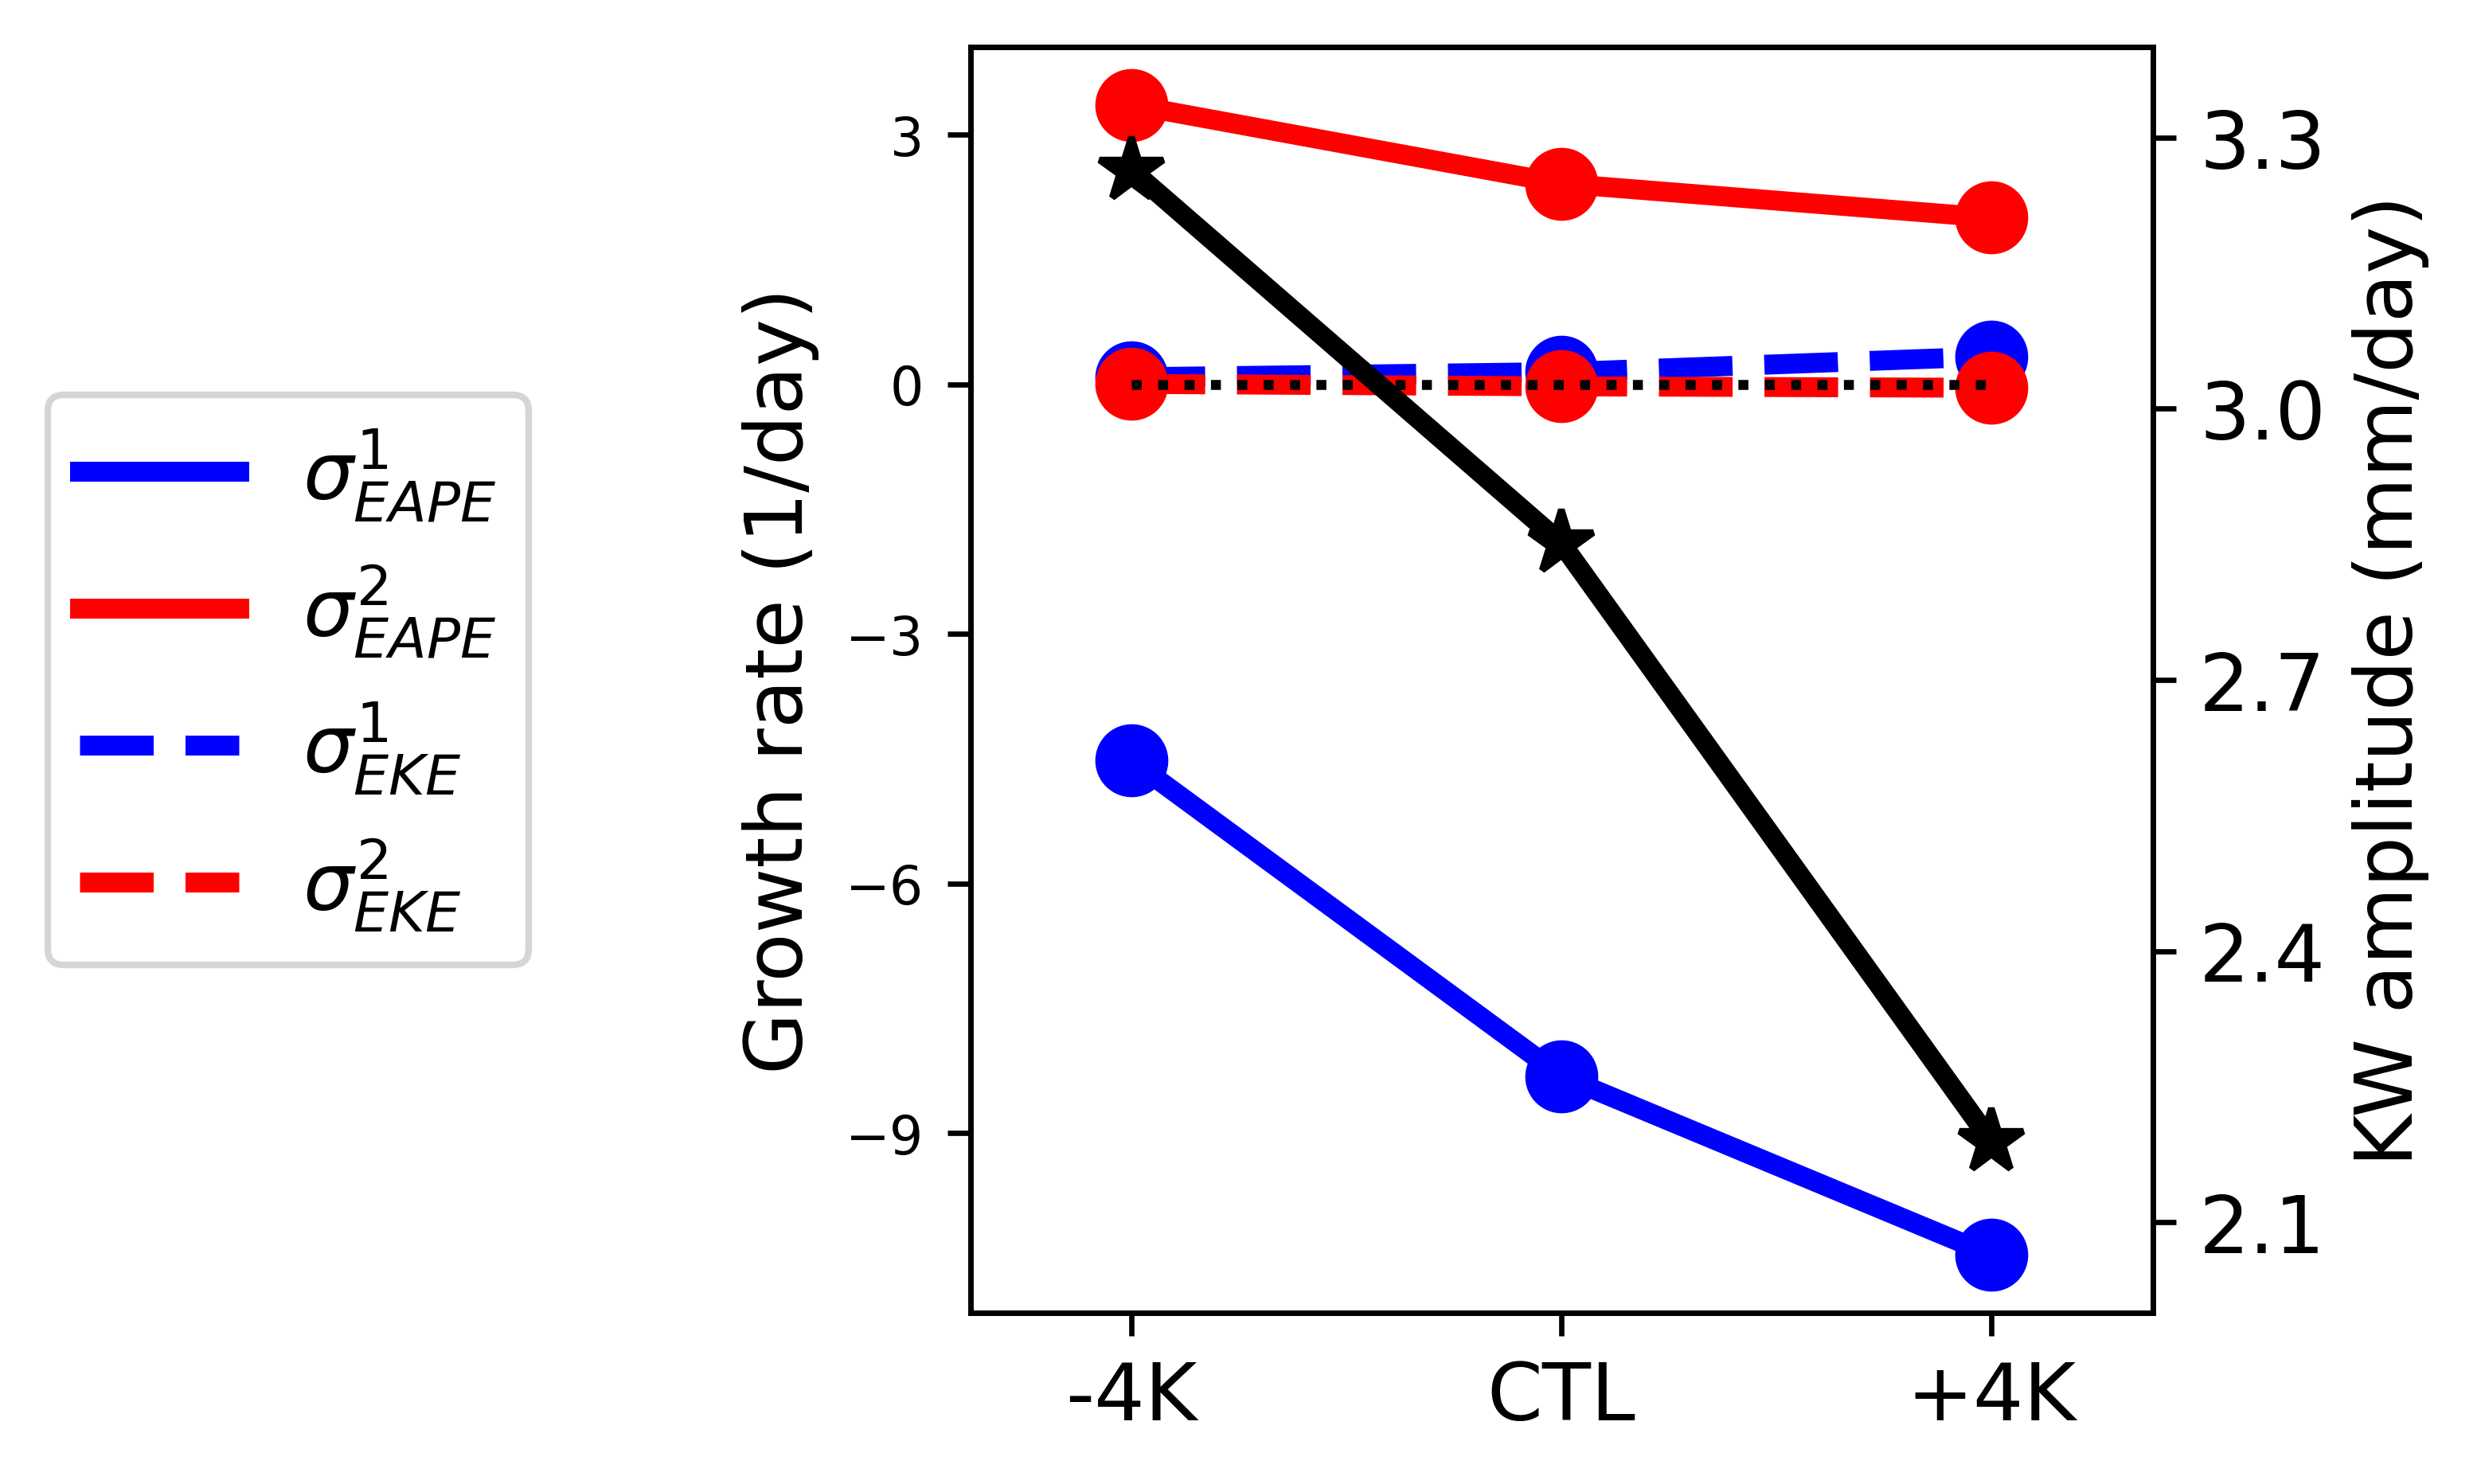

In [11]:
###############################
# Fig. 7: kwamp, G, GR 
############################
zero = np.zeros([3])
for i in range(0,1):#0,4): # 0: plotting all, 1: plotting EAPEGR only, 2: plotting EKEGR only, 3: plot amplitude only
    fig,ax = plt.subplots(1,1,figsize=(5.5, 3.44),dpi=600)
    plt.subplots_adjust(left=0.4,right=0.85,top=0.97,bottom=0.2)
    plt.rcParams.update({'font.size': 12})
    #
    plt.subplot(1,1,1)
    if i != 2:
        ax.plot(SST_max, EAPEGR1, color='b', marker='o',linewidth=3,markersize=10)
    if i != 2 and i != 3:
        ax.plot(SST_max, EAPEGR2, color='r', marker='o',linewidth=3,markersize=10)
    if i != 1 and i != 3:
        ax.plot(SST_max, EKEGR1, linestyle ='dashed',color='b',marker='o',linewidth=3,markersize=10)
    if i != 1 and i != 3:
        ax.plot(SST_max, EKEGR2, linestyle ='dashed',color='r', marker='o',linewidth=3,markersize=10)
    if i != 3:
        ax.plot(SST_max, zero,'k:')
    ax.set_ylabel('Growth rate (1/day)',fontsize=12)
    ax.set_yticks(np.arange(-9,6,3),fontsize=12)
    ax.set_xlim([21.5,32.5]) 
    if i == 0:
        legend = ax.legend(['$\u03C3^{\t{1}}_{\t{EAPE}}$','$\u03C3^{\t{2}}_{\t{EAPE}}$',\
                            '$\u03C3^{\t{1}}_{\t{EKE}}$','$\u03C3^{\t{2}}_{\t{EKE}}$'],\
              bbox_to_anchor=(-0.34, 0.5), loc='center right',fontsize=12)
    elif i == 1:
        legend = ax.legend(['$\u03C3^{\t{1}}_{\t{EAPE}}$','$\u03C3^{\t{2}}_{\t{EAPE}}$'],\
              bbox_to_anchor=(-0.34, 0.5), loc='center right',fontsize=12)
    elif i == 2:
        legend = ax.legend(['$\u03C3^{\t{1}}_{\t{EKE}}$','$\u03C3^{\t{2}}_{\t{EKE}}$'],\
              bbox_to_anchor=(-0.34, 0.5), loc='center right',fontsize=12)
    elif i == 3:
        legend = ax.legend(['$\u03C3^{\t{1}}_{\t{EAPE}}$'],\
              bbox_to_anchor=(-0.34, 0.5), loc='center right',fontsize=12)        
    # Remove dots in legend
    for handle in legend.legendHandles:
        handle.set_marker('')

    #
    ax2 = ax.twinx()
    ax2.plot(SST_max, kw_amp,color='k', marker='*',linewidth=3,markersize=10)
    ax.set_xticks(SST_max,('-4K','CTL','+4K'),fontsize=12)
    ax2.set_ylabel('KW amplitude (mm/day)',color='k',fontsize=12)
    ax2.set_yticks(np.arange(2.1,3.6,0.3),fontsize=12)
    ax2.set_ylim([2.0,3.4])
    #
    if i == 0:
        plt.savefig(figdir+'fig7_SST_kwamp_EAPEGR_EKEGR_1st_2nd.png',dpi=600)
    elif i == 1:
        plt.savefig(figdir+'fig7_SST_kwamp_EAPEGR.png',dpi=600)
    elif i == 2:
        plt.savefig(figdir+'fig7_SST_kwamp_EKEGR.png',dpi=600)
    elif i == 3:
        plt.savefig(figdir+'fig7_SST_kwamp_EAPEGR1.png',dpi=600)
    plt.show()
    plt.close()

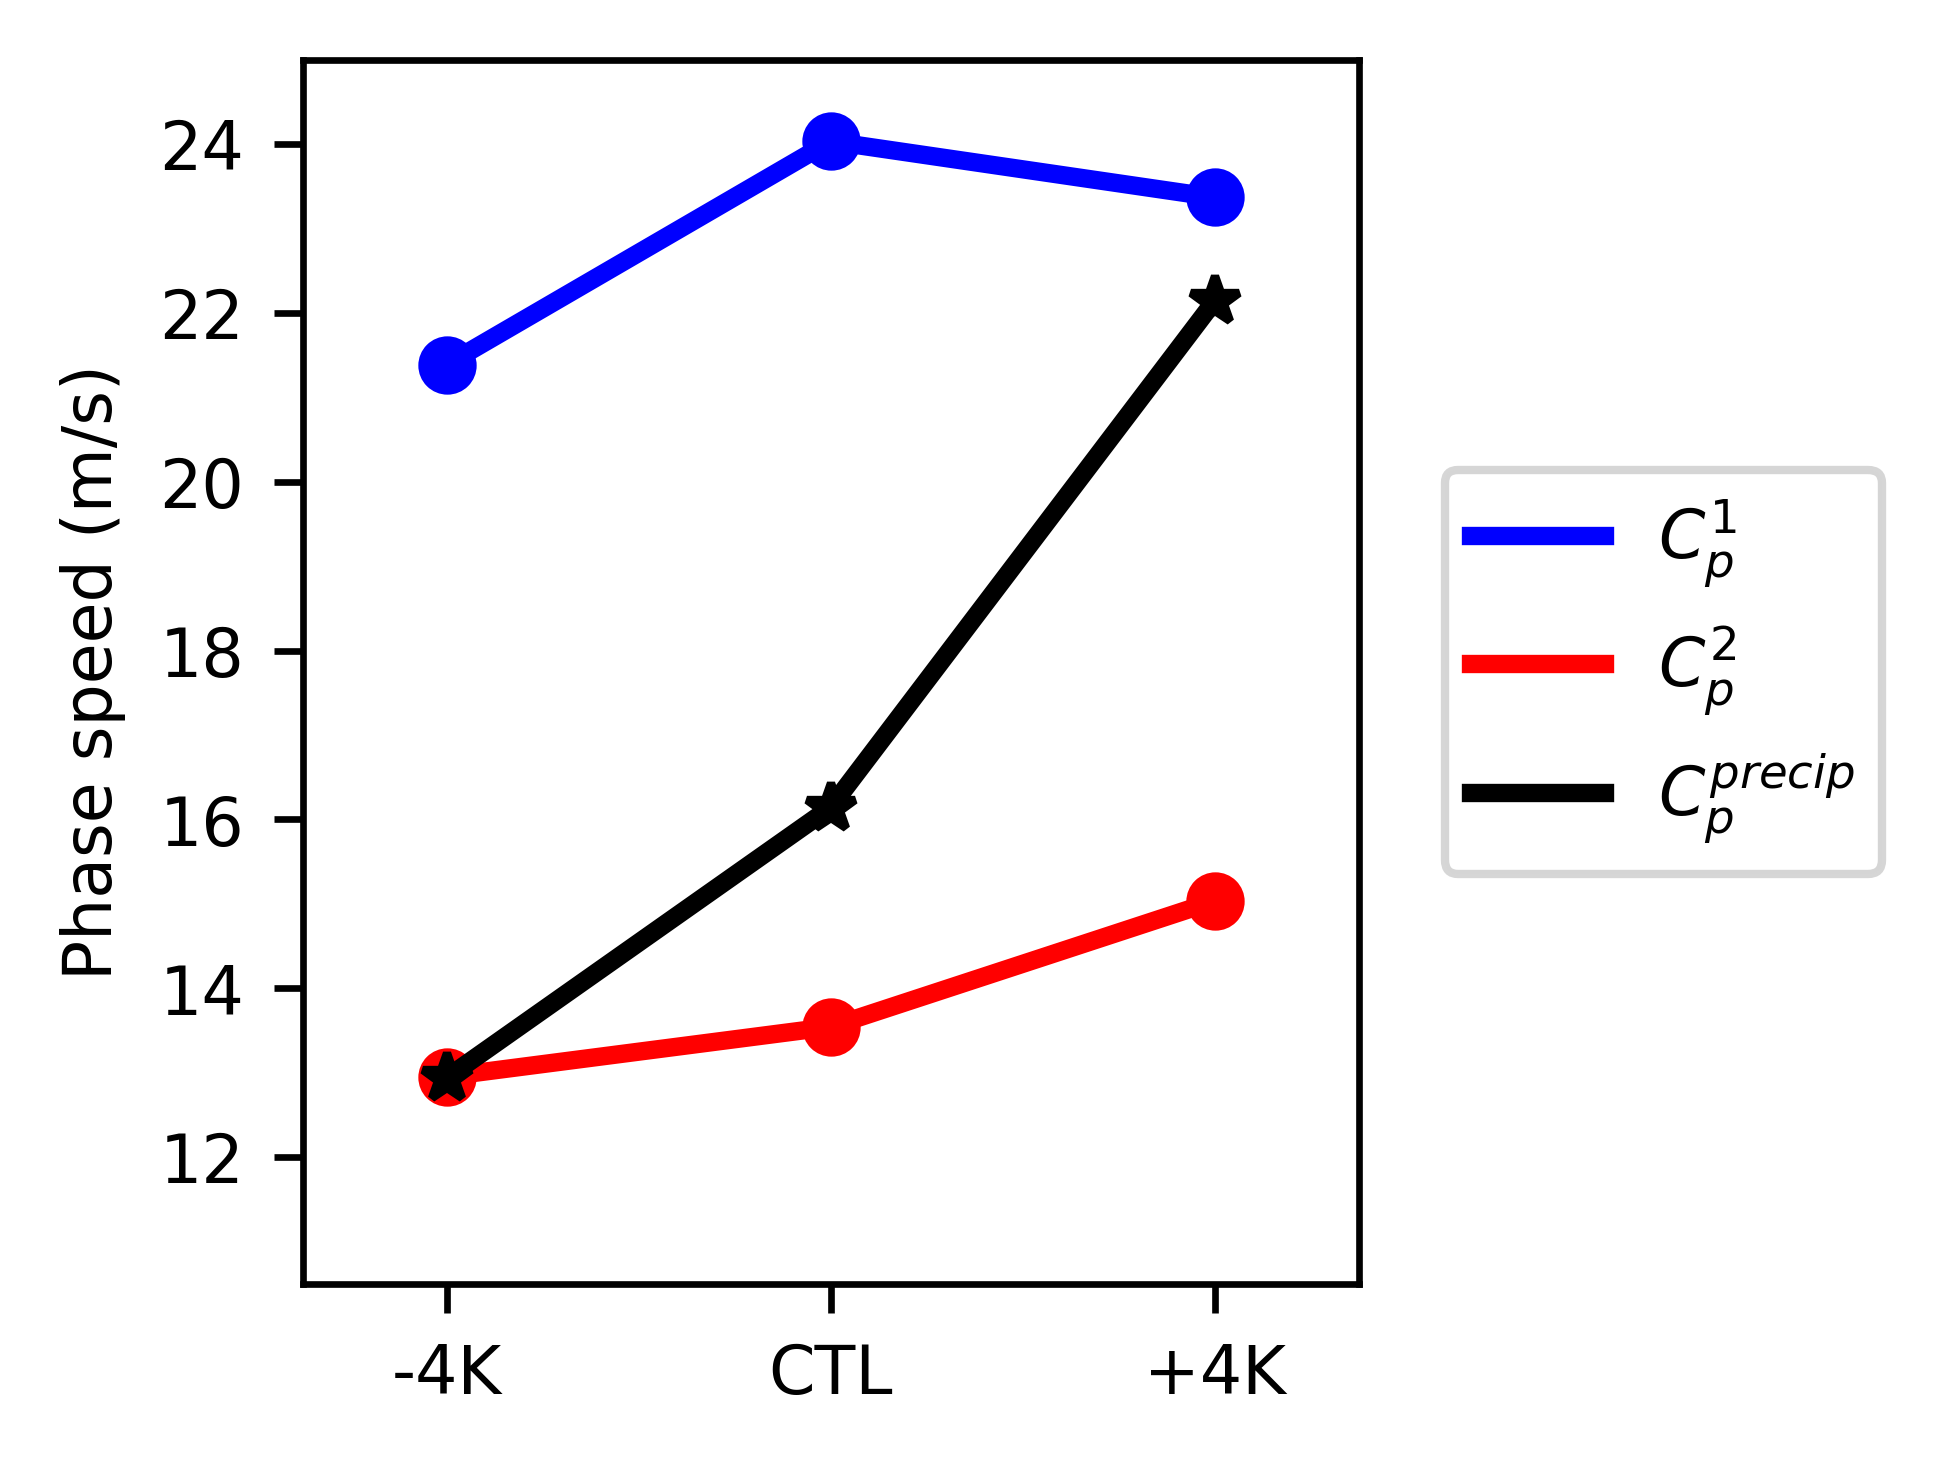

In [48]:
############################
# Ｆig. 8: Plot phase speed
#############################
fig,axes = plt.subplots(1,1,figsize=(3.2, 2.4),dpi=600)
plt.subplots_adjust(left=0.15,right=0.7,top=0.95,bottom=0.1,wspace=0.1)
plt.rcParams.update({'font.size': 8.5})
plt.subplot(1,1,1)
plt.plot(SST_max, Cp1, 'b-o',linewidth=2.2)
plt.plot(SST_max, Cp2, 'r-o',linewidth=2.2)
plt.plot(SST_max, Cp, 'k-*', linewidth=2.2)
plt.xticks(SST_max,('-4K','CTL','+4K'))
plt.yticks(np.arange(12,26,2))
plt.axis([21.5,32.5,10.5,25])
plt.ylabel('Phase speed (m/s)')
plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
ax = plt.gca()
legend = ax.legend(['$C^{\t{1}}_{\t{p}}$','$C^{\t{2}}_{\t{p}}$','$C^{\t{precip}}_{\t{p}}$'],\
          bbox_to_anchor=(1.05, 0.5), loc='center left',fontsize=8)
# Remove dots in legend
for handle in legend.legendHandles:
        handle.set_marker('')
#plt.savefig(figdir+'fig8_SST_Cp1_Cp2.png',dpi=600)
plt.savefig(figdir+'fig8_SST_Cp1_Cp2_Cp_from_Hovmoller.png',dpi=600)
plt.show()

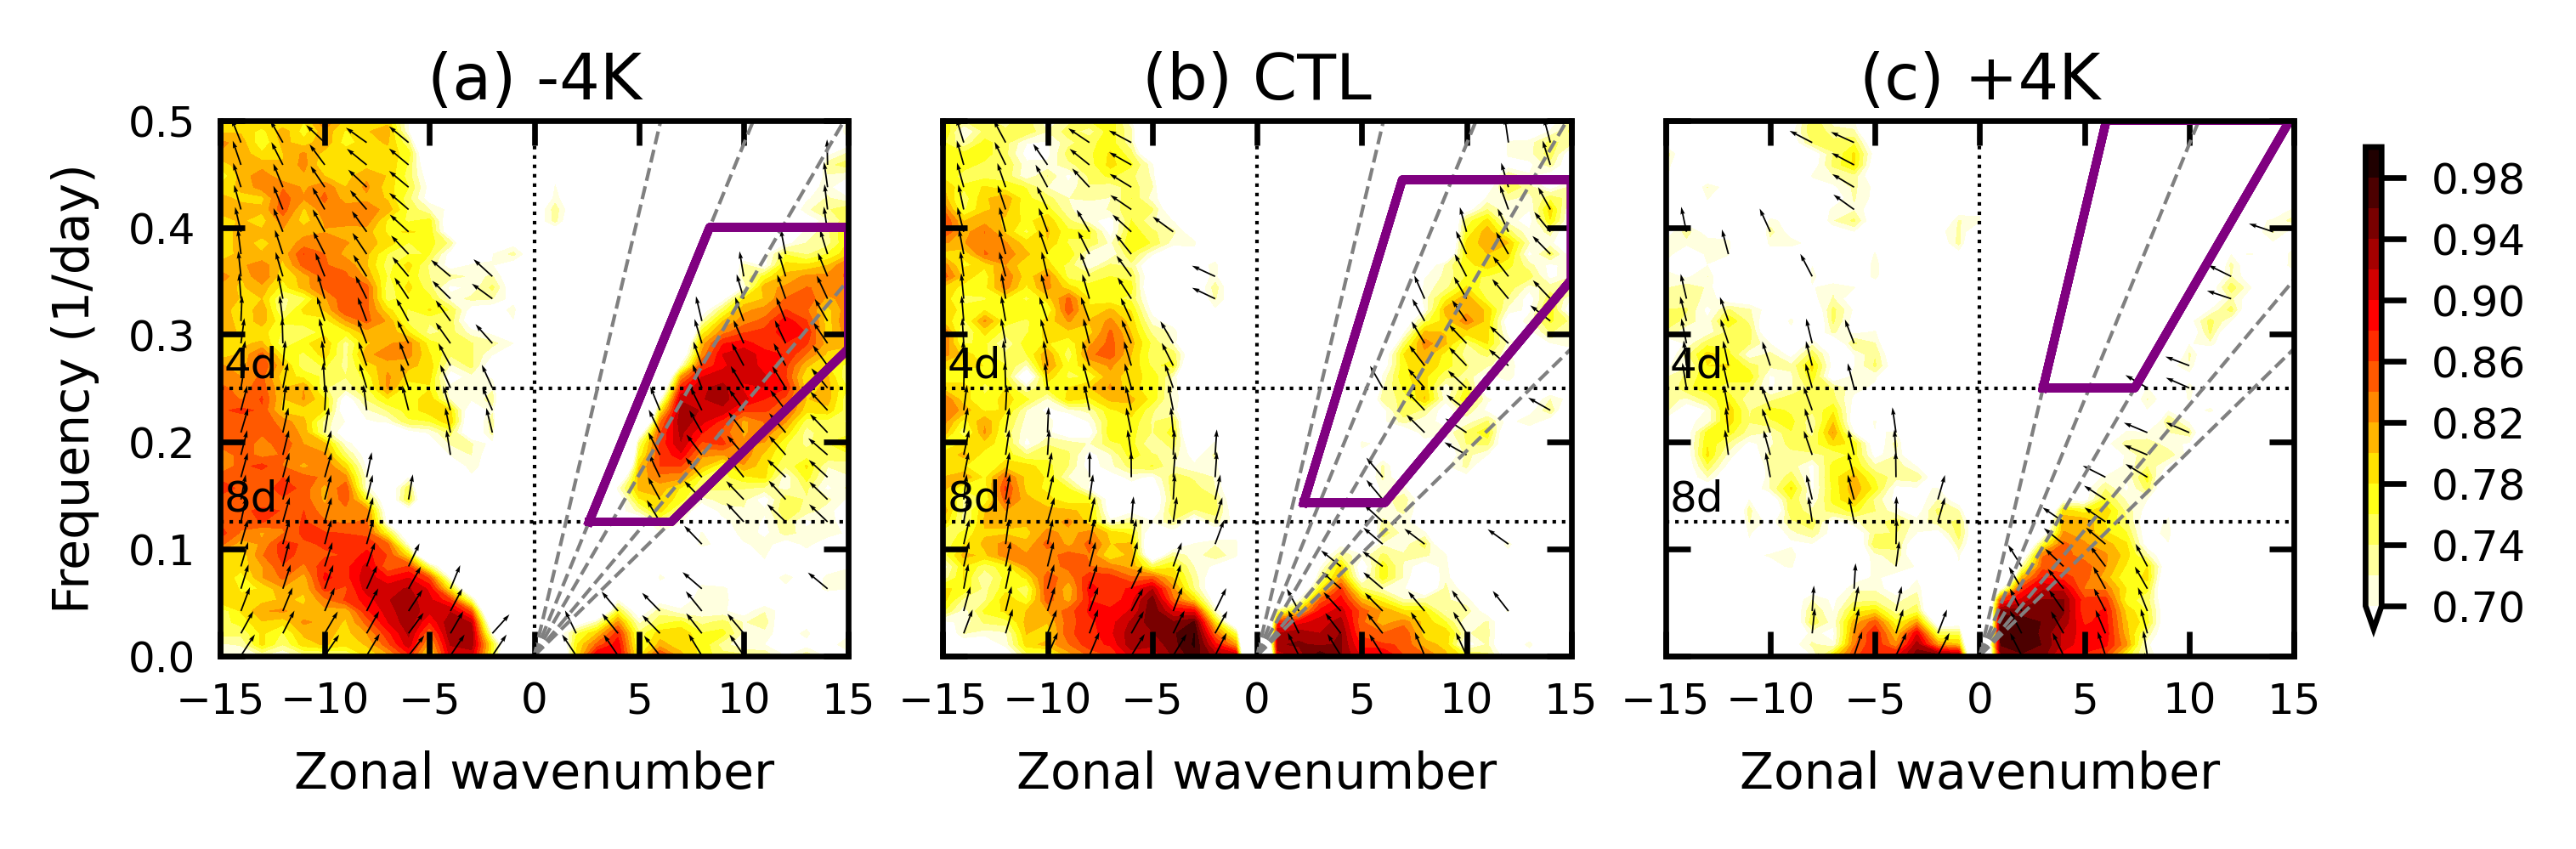

In [51]:
#########################################################
# Fig. 9: Coherence squared in wavenumber-frequency space
##########################################################
vname = list(['pr_DCIN','pr_SF','pr_PW','pr_colT','PCQ1_PCQ2'])
axid = np.array([0,1,2]).astype('int')
xid = np.array([0,0,0]).astype('int')
yid = np.array([0,1,2]).astype('int')
coh_min = 0.7
plot_coh2 = 1 # or 1. If 0, plot sin; if 1, plot coh2

for iplt in range(4,5):# plot coh^2 between PCQ1 and PCQ2 only    
    
    if plot_coh2==1:
        figname = 'fig9_coh2_'+vname[iplt]+'.png'

        v_cf = globals() ['coh_'+vname[iplt]]
        v_sin = globals() ['sin_'+vname[iplt]]
        v_cos = globals() ['cos_'+vname[iplt]]

        v_sin_new = np.where(v_cf>=coh_min, v_sin, np.nan)
        v_cos_new = np.where(v_cf>=coh_min, v_cos, np.nan) 

        clev = np.arange(coh_min,1,0.02)
        ticks = np.arange(coh_min,1,0.04)     
    
    fig,ax = plt.subplots(1,3,figsize=(5.5, 1.5),dpi=600)
    plt.subplots_adjust(left=0.1,right=0.95,top=0.9,bottom=0.2,wspace=0.15)
    plt.rcParams.update({'font.size': 6})
    for v in range(0,3):

        #####################
        # Dispersion curve and CCKW band
        d = np.array([4,8])#([3,6]) # mark 3, 6, 20 day in WK1999
        dname = list(['4d','8d'])#(['3d','6d'])
        if v == 0:
            he = np.array([8,25,50]) 
            hname = list(['8m','25m','50m'])
        elif v==1:
            he = np.array([12,25,90]) # mark equivalent depth for sym spectrum
            hname = list(['12m','25m','90m'])
        elif v == 2:
            he = np.array([25,90,150]) 
            hname = list(['25m','90m','150m'])
        he_all = np.array([8, 12, 25, 50, 150])


        # dispersion curve
        xloc = np.array([12,12,4.9])
        yloc = np.array([0.29,0.47,0.47])
        cp = (g*he_all)**0.5
        zwnum_goal = 0.5/s2d/cp*2*np.pi*re
        # CCKW band
        s_min = (g*he[0])**0.5/(2*np.pi*re)*s2d #slope of he = 8m
        s_max = (g*he[2])**0.5/(2*np.pi*re)*s2d #slope of he = 90m
        kw_tmax_list = np.array([8,7,4])
        kw_tmax = kw_tmax_list[v]
        fmax = np.array([0.4,1/2.25,0.5])
        kw_x = np.array([1/kw_tmax/s_max, 1/kw_tmax/s_min,     15,  15, fmax[v]/s_max, 1/kw_tmax/s_max])
        kw_y = np.array([1/kw_tmax,             1/kw_tmax,  15*s_min, fmax[v],      fmax[v],  1/kw_tmax])
        ax[yid[v]] = plt.subplot(1,3,axid[v]+1)
        
        # plot coh2 and sin, cos
        if plot_coh2==1:
            cf = plt.contourf(x, y, v_cf[:,:,v], cmap='hot_r', levels = clev, extend='min') 
        else:
            #cf = plt.contourf(x, y, v_cf[:,:,v], cmap=get_cmap(RWB), levels = clev, extend='neither') 
            cf = plt.contourf(x, y, v_cf[:,:,v], cmap='RdBu_r', levels = clev, extend='neither')
        
        # Mark 3, 6, 20 day period:
        for dd in range(0,np.size(d)):
            plt.plot([-15,15], [1/d[dd],1/d[dd]], 'k',linewidth=0.5, linestyle=':')#'dashed')
            plt.text(-14.8,1/d[dd]+0.01,dname[dd], fontsize=6)
        # Mark CCKW dispersion relationship:
        for hh in range(0,np.size(he_all)):
            plt.plot([0,zwnum_goal[hh]],[0,0.5],'grey',linewidth=0.5,linestyle='dashed')#,linestyle='dashed')#linestyle=':')#linestyle=(0,(5,5)))
            #plt.text(xloc[hh],yloc[hh],hname[hh], fontsize=15)             
        # Mark zwnum == 0:
        plt.plot([0,0],[0,0.5],'k',linewidth=0.5,linestyle=':')#'dashed')
        # Mark CCKW band:
        # y=s*x
        for kk in range(0,np.size(kw_x)):
            plt.plot(kw_x,kw_y,'purple',linewidth=1.2,linestyle='solid')
        
        plt.title(title[v], pad=3, loc='center',fontsize=9)
        if v == 0:
            plt.ylabel('Frequency (1/day)',fontsize=7)
        plt.xlabel('Zonal wavenumber',fontsize=7)
        plt.axis([-15,15,0,0.5])
        plt.xticks([-15,-10,-5,0,5,10,15])
        plt.yticks(np.arange(0,0.6,0.1))
        plt.tick_params(bottom=True,top=True,left=True,right=True)
        if v == 0:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        else:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        plt.tick_params(direction="in")

        if plot_coh2==1:
            plt.quiver(zwnum[::2],freq[::2],v_sin_new[::2,::2,v],v_cos_new[::2,::2,v],units='inches',scale=20)
        
        # Mark centroid of the data
        #plt.plot(zwnum_ave[v],freq_ave[v],'k*',markersize=3)
    cb = fig.colorbar(cf,ax=ax[:],orientation = 'vertical',shrink=.9,\
                    fraction=0.1, aspect=30, pad=0.03)
    cb.ax.tick_params(labelsize=6)
    cb.set_ticks(ticks)  
    plt.savefig(figdir+figname,format='png', dpi=600)
    plt.show()
    plt.close()                                

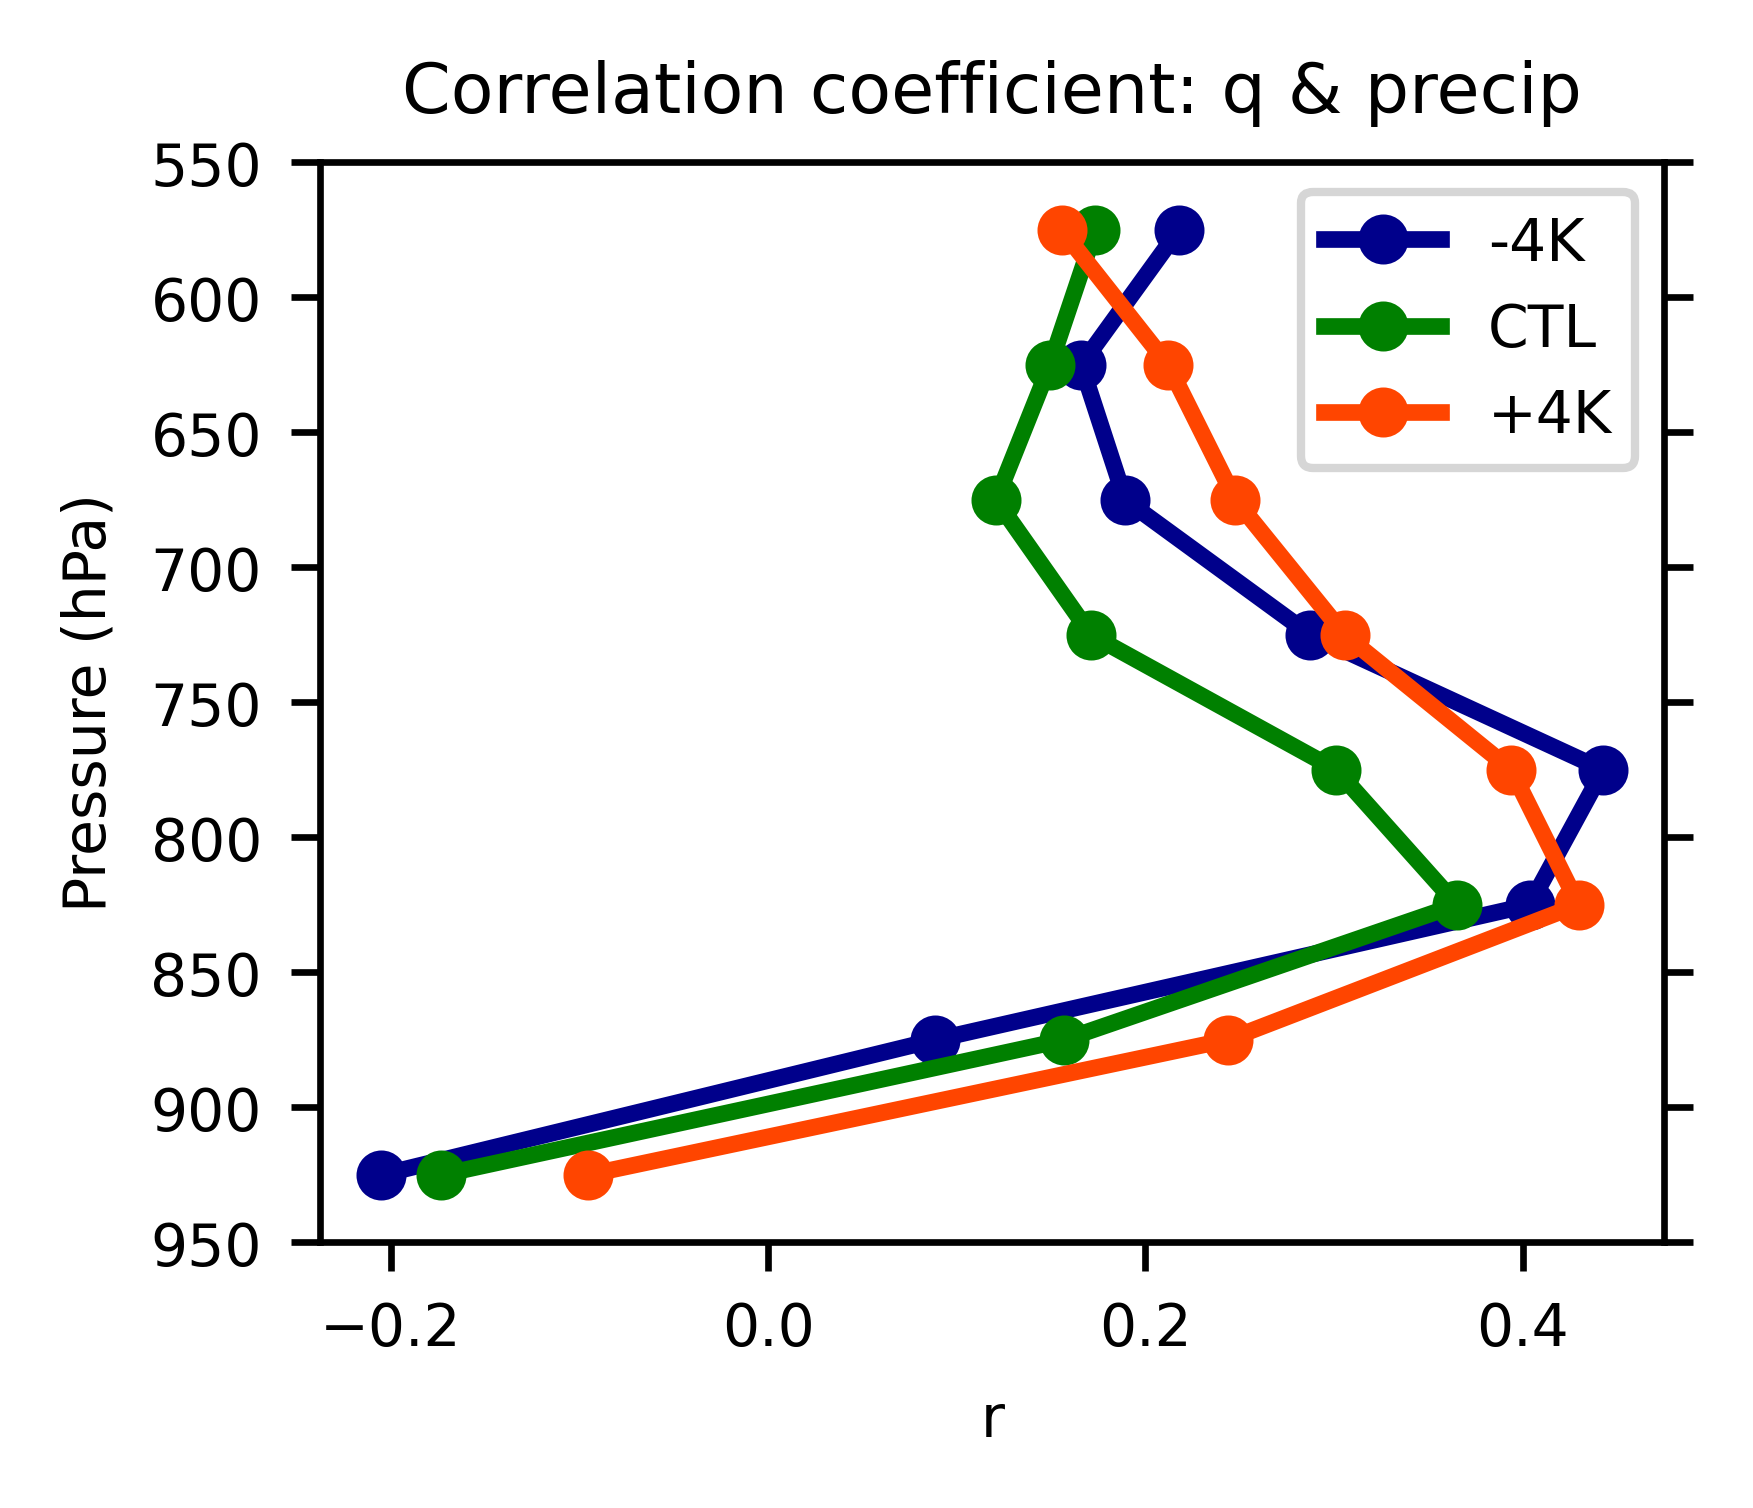

In [44]:
##############################################
# Fig.10: Plot correlation coefficient between q_ano and precip_ano (not just KW)
############################################
for icase in range(0,3):
    if icase == 0:
        r_below_500 = np.empty([np.size(plev_r),3])
    r_below_500[:,icase] = np.where(plev_r<550, np.nan, r[:,icase])

font = 7
fig,axes = plt.subplots(1,1,figsize=(3.2, 2.4),dpi=600)
plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.15,wspace=0.1)
plt.rcParams.update({'font.size': font})
plt.plot(r_below_500[:,0], plev_r, color='darkblue',marker='o',markersize=5, linewidth=2)
plt.plot(r_below_500[:,1], plev_r, color='green',marker='o',markersize=5, linewidth=2)
plt.plot(r_below_500[:,2], plev_r, color='orangered',marker='o',markersize=5, linewidth=2)
plt.ylim([550,np.max(plev_r)])
plt.yticks( np.arange(550, 1000, 50) )
plt.tick_params(bottom=True,top=False,left=True,right=True)
plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
plt.gca().invert_yaxis()
plt.xlabel('r')
plt.title('Correlation coefficient: q & precip')
plt.ylabel('Pressure (hPa)')
plt.legend(['-4K','CTL','+4K'])
plt.savefig(figdir+'fig10_corrcoef_q_pr_level.png',dpi=600)
plt.show()

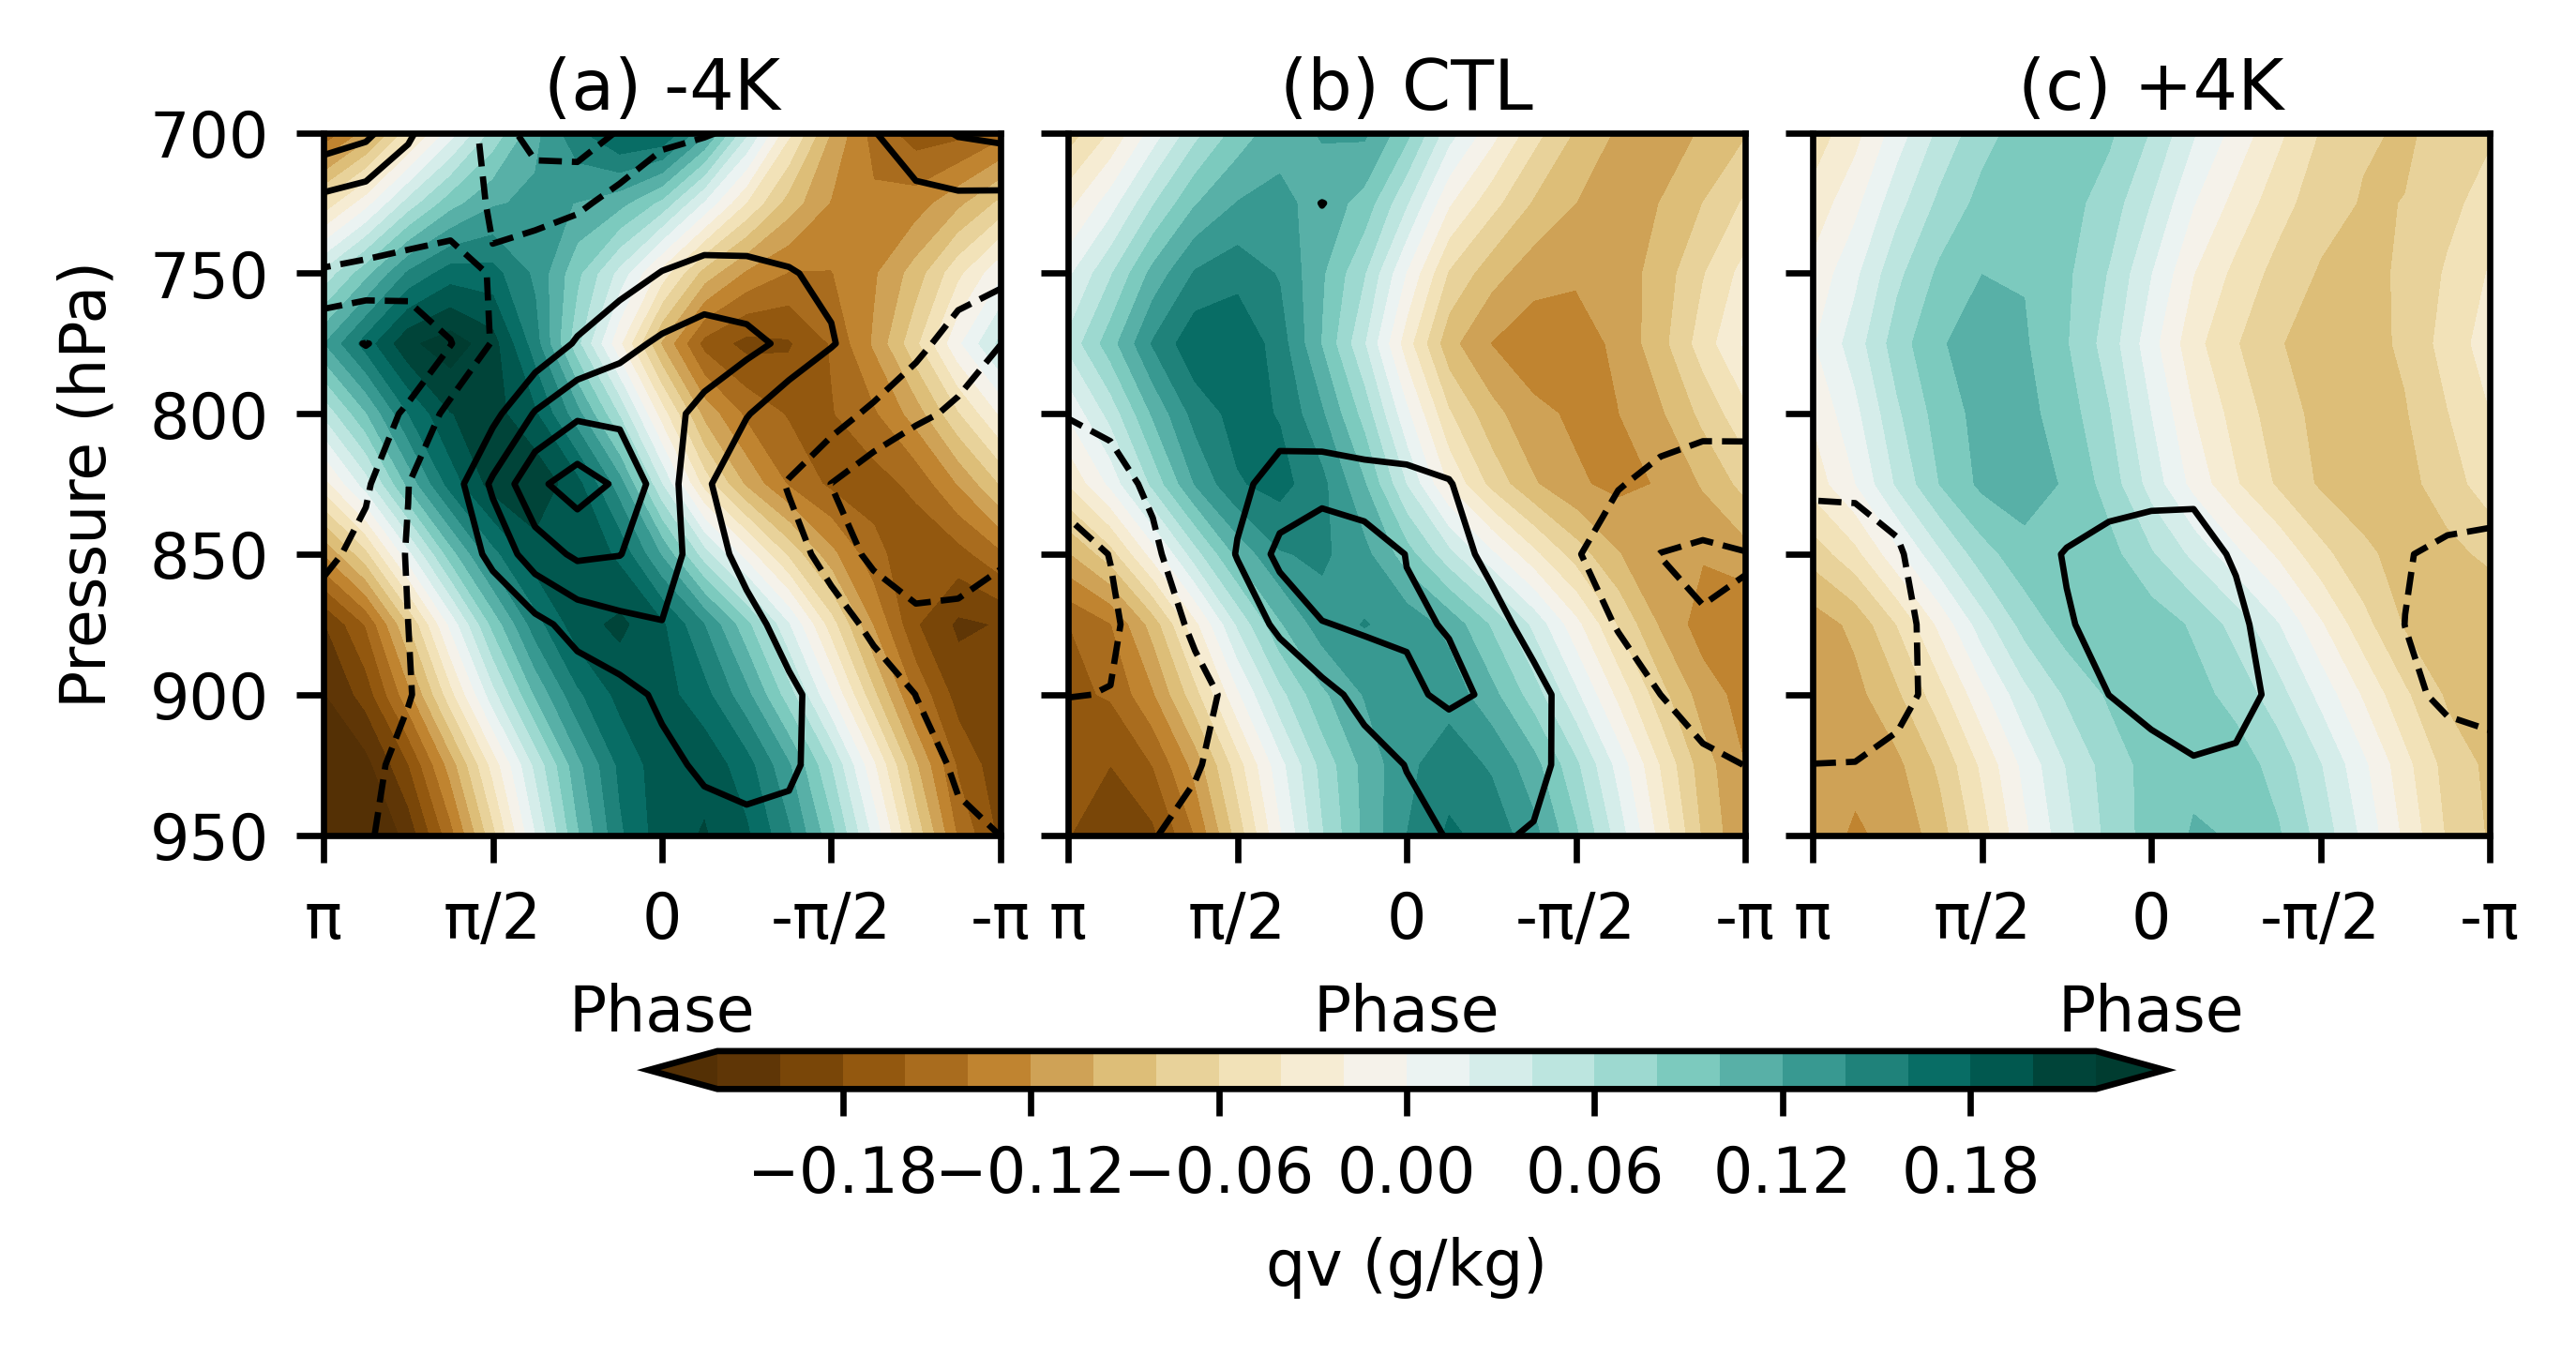

In [9]:
#####################################
# Fig. 11: Plot KW compostie q vertical structure and residual diabatic heating together
#############################################
clev_n = np.arange(-0.96,0,0.08)
clev_p = np.arange(0.08,1.04,0.08)

clev_n_Q = np.arange(-0.75,0,0.15)#+0.15/2
clev_p_Q = np.arange(0.15,0.9,0.15)#-0.15/2

title = list(['(a) -4K', '(b) CTL','(c) +4K'])
font = 8
for iplt in range(1,2): # only plot qv, not RH
    fig,axes = plt.subplots(1,3,figsize=(5.5, 2.4),dpi=600)
    plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.1,wspace=0.1)
    plt.rcParams.update({'font.size': font})
    #*0.5

    for icase in range(0,3):
        plt.subplot(1, 3,icase+1)
        ax = plt.gca()
        plt.title(title[icase], pad=3, loc='center',fontsize=9)
        xx, yy = np.meshgrid(phase,plev_ref)
        clev = np.arange(-0.22,0.24,0.02)
        cf  = plt.contourf(xx, yy, qv_kw_small[:,:,icase].T, levels=clev, cmap='BrBG', extend='both' )

        cn_p_Q = plt.contour(xx, yy, Q_res_kw[:,:,icase].T, levels=clev_p_Q, colors='k', linewidths=0.8)
        cn_n_Q = plt.contour(xx, yy, Q_res_kw[:,:,icase].T, levels=clev_n_Q, colors='k', linestyles='dashed',linewidths=0.8) 
        plt.ylim([700,950])
        plt.xlabel('Phase')
        plt.yticks(np.arange(700,1000,50))
        plt.gca().invert_yaxis()
        #plt.xticks(bin_simple2,('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=8)
        plt.xticks(bin_simple2,(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=8)
        plt.tick_params(bottom=True,top=False,left=True,right=False)
        if icase == 0:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
            ax.set_ylabel('Pressure (hPa)',fontsize=font)
        elif icase == 1:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        elif icase == 2:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)

    cb = plt.colorbar(cf, ax = axes, orientation = 'horizontal', shrink=.7, aspect=40,pad=0.2) 
    cb.set_label('qv (g/kg)')
    plt.savefig(figdir+'fig11_KWcomposite_qv_Q_onlybelow700_phase_reversed.png',dpi=600)  
    plt.show()

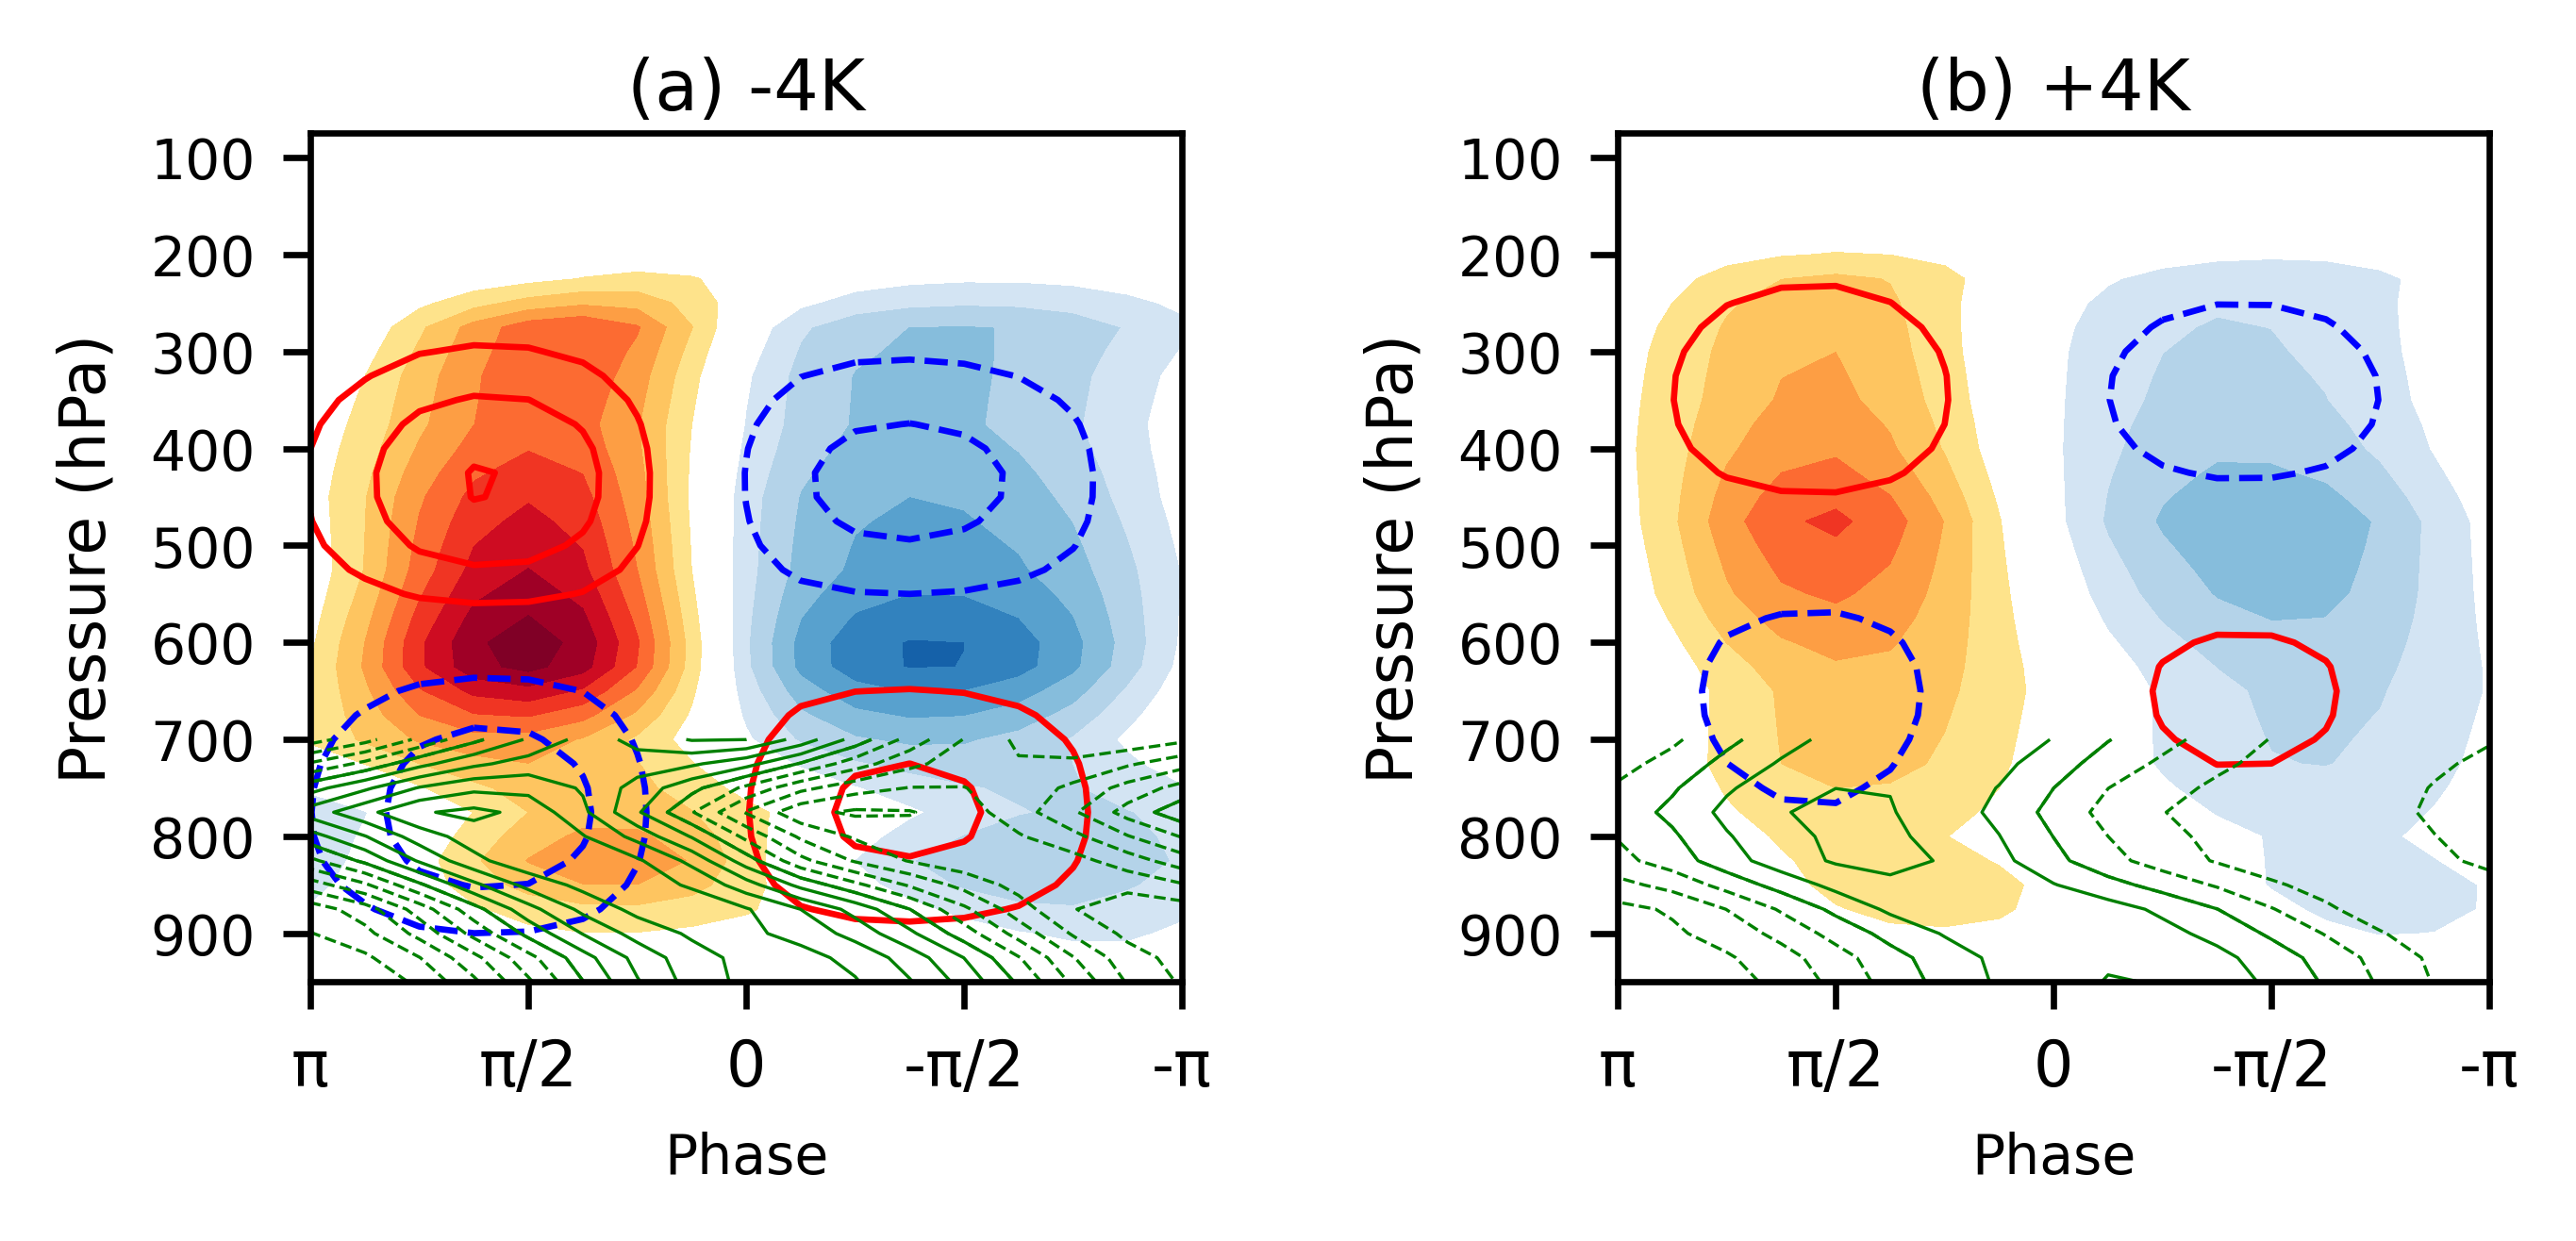

In [11]:
############################
# Fig.12: Plot schematic diagram (KW composite vertical structure of Q and 2nd mode T)
##############################
plev = plev_ref

title_noabc = list(['(a) -4K','CTL','(b) +4K'])
clev_0 = 0
font = 8
i_list = np.array([0,2])

for iplt in range(0,1): 
    
    fig,axes = plt.subplots(1,2,figsize=(5.5, 2),dpi=600)
    plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.15,wspace=0.5)
    plt.rcParams.update({'font.size': font})
    cn2_color = list(['g','k'])
    if iplt == 0:
        clev = np.arange(-2.4,2.7,0.3) #202402226, removed
        #clev = np.arange(-2.4,2.55,0.15) # 202402226
        clev_n = np.arange(-0.96,0,0.08) #np.arange(-0.08,0,0.08)
        clev_p =  np.arange(0.08,1.04,0.08) #np.arange(0.08,0.16,0.08) 
        clev2_n = np.arange(-0.28,0,0.04)+0.02
        clev2_p = np.arange(0.04,0.28,0.04)-0.02
        var_cf  = globals()['Q_kw']
        var_cn  = globals()['T2_kw']
        var_cn2 = globals()['qv_kw_LF']
        
    for ii in range(0,2): #icase
        
        i = i_list[ii]
        plt.subplot(1,2,ii+1)
        ax = plt.gca()
        plt.title(title_noabc[i], pad=3, loc='center',fontsize=9)
        xx, yy = np.meshgrid(phase, plev_ref)
        if iplt == 0:
            cf  = plt.contourf(xx, yy, var_cf[:,:,i].T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        # Plot 2nd mode T
        cn_p = plt.contour(xx, yy, var_cn[:,:,i].T, levels=clev_p, colors='r', linewidths=0.8)
        cn_n = plt.contour(xx, yy, var_cn[:,:,i].T, levels=clev_n, colors='b', linestyles='dashed',linewidths=0.8)
        # Plot q
        cnq_p = plt.contour(xx, yy, var_cn2[:,:,i].T, levels=clev2_p, colors=cn2_color[iplt], linewidths=0.4)
        cnq_n = plt.contour(xx, yy, var_cn2[:,:,i].T, levels=clev2_n, colors=cn2_color[iplt], linestyles='dashed',linewidths=0.4)
    
        plt.ylim([np.min(plev),np.max(plev)])
        plt.yticks(np.arange(100,1000,100))
        plt.gca().invert_yaxis()
        #plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        plt.xticks(np.arange(-pi,pi+pi/2,pi/2),(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=True,right=False)
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        ax.yaxis.set_label_position("left")
        ax.set_ylabel('Pressure (hPa)',fontsize=font)
        plt.xlabel('Phase')
        
    if iplt == 0:
        plt.savefig(figdir+'fig12_Schematic_phase_reversed.png',dpi=600)
    plt.show()


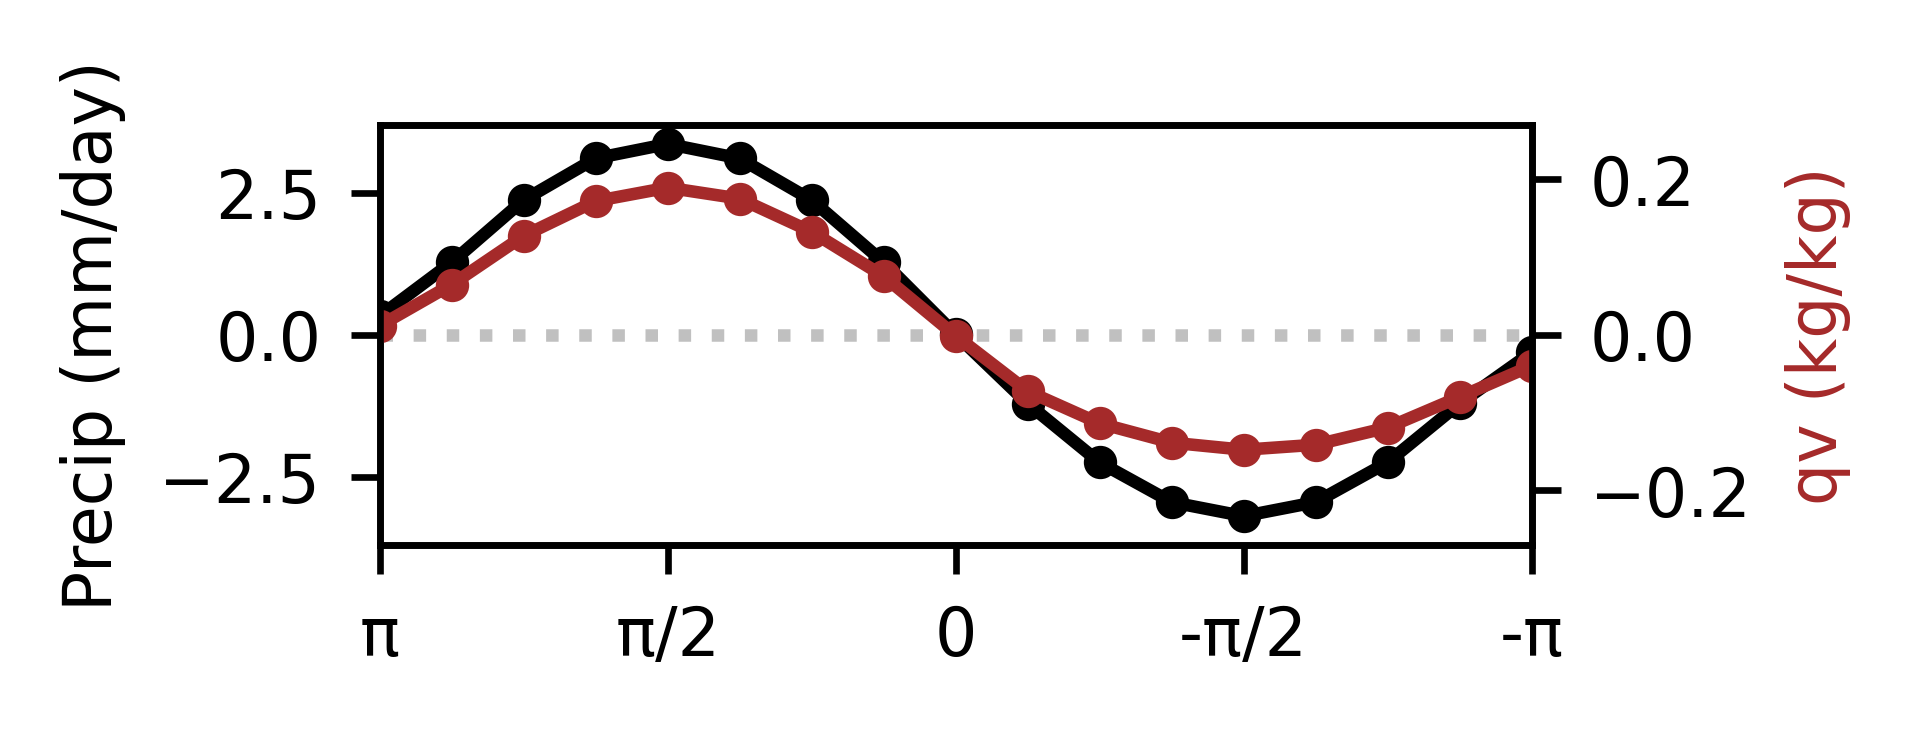

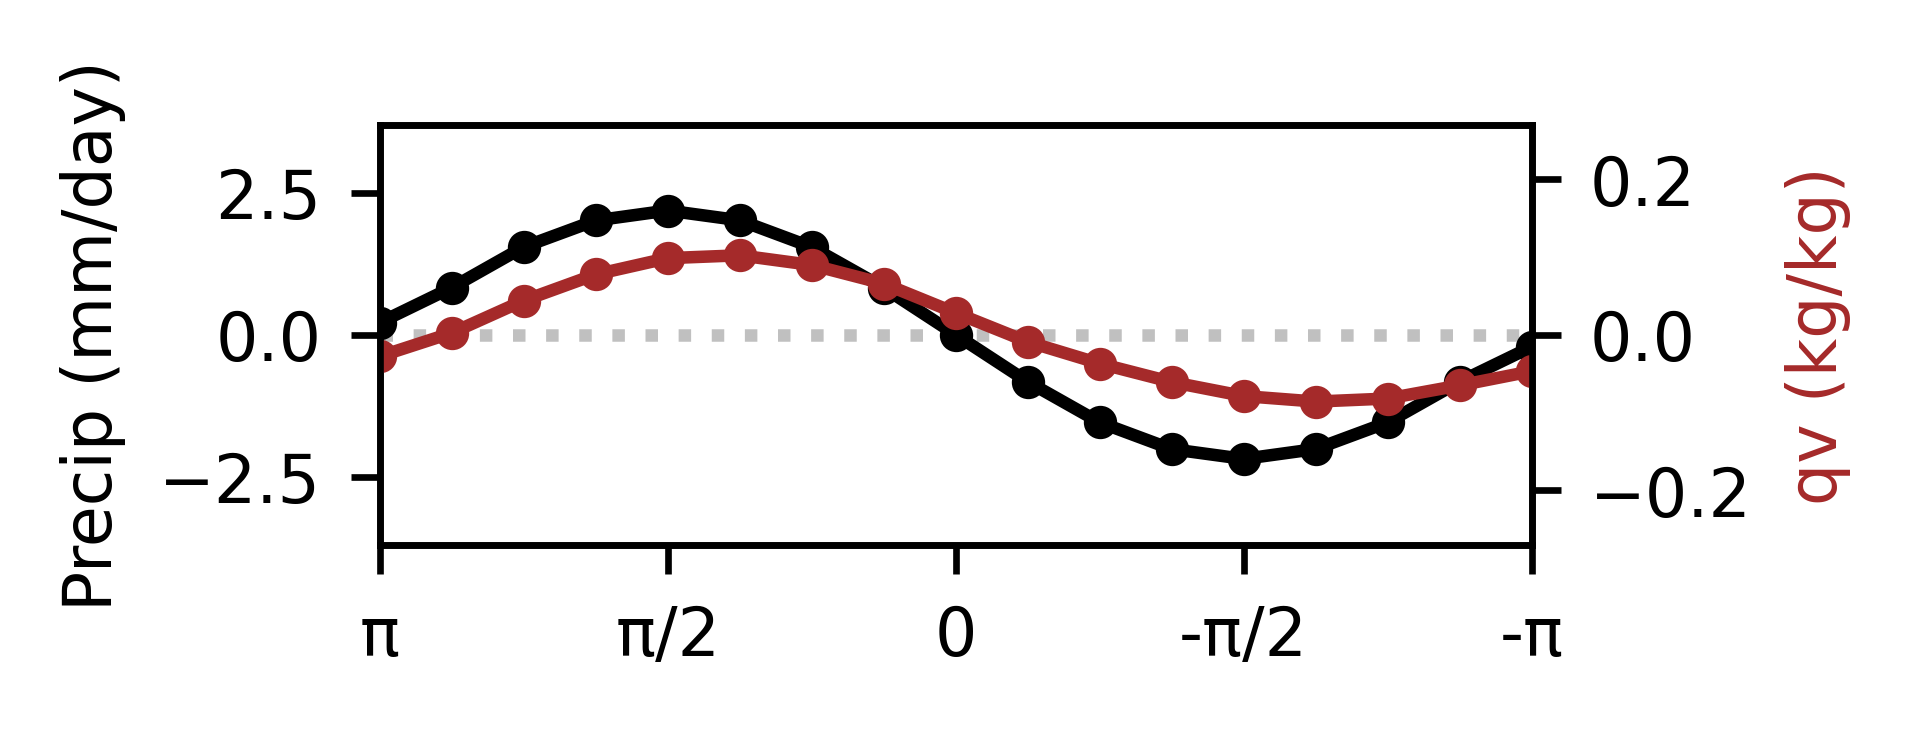

In [12]:
###############################################
# Fig.13: Plot schematic diagram (lower plot), precip and DCIN 
######################################################
zero = np.zeros([nphase])

fig,ax = plt.subplots(1,1,figsize=(3.2, 1),dpi=600)
plt.subplots_adjust(left=0.2,right=0.8,top=0.9,bottom=0.2)
plt.subplot(1,1,1)
ax.plot(phase, zero, color='silver',linestyle='dotted')
ax.plot(phase, pr_kw[:,0],color='k',marker='o',markersize=3)
ax.set_xlim([-pi,pi])
ax.set_ylim([-3.7, 3.7])
ax.set_ylabel('Precip (mm/day)')
#
ax2 = ax.twinx()
ax2.plot(phase, qv_kw_lf[:,0],color='brown',marker='o',markersize=3)
ax2.set_ylim([-0.27, 0.27])
ax2.set_ylabel('qv (kg/kg)',color='brown')
#ax.set_xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
ax.set_xticks(np.arange(-pi,pi+pi/2,pi/2),(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
plt.savefig(figdir+'fig13_pr_qvlf_-4K_phase_reversed.png',dpi=600)
plt.show()

fig,ax = plt.subplots(1,1,figsize=(3.2, 1),dpi=600)
plt.subplots_adjust(left=0.2,right=0.8,top=0.9,bottom=0.2)
plt.subplot(1,1,1)
ax.plot(phase, zero, color='silver',linestyle='dotted')
ax.plot(phase, pr_kw[:,2],color='k',marker='o',markersize=3)
ax.set_xlim([-pi,pi])
ax.set_ylim([-3.7, 3.7])
ax.set_ylabel('Precip (mm/day)')
#
ax2 = ax.twinx()
ax2.plot(phase, qv_kw_lf[:,2],color='brown',marker='o',markersize=3)
ax2.set_ylim([-0.27, 0.27])
ax2.set_ylabel('qv (kg/kg)',color='brown')
#ax.set_xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
ax.set_xticks(np.arange(-pi,pi+pi/2,pi/2),(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
plt.savefig(figdir+'fig12_pr_qvlf_+4K_phase_reversed.png',dpi=600)
plt.show()